### Necessary Imports and Settings
    for any step in the following notebook

In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import cmb_anomaly_utils as cau

In [2]:
from matplotlib.lines import Line2D

plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('legend', facecolor='white', edgecolor='k', framealpha=1)
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['xtick.labelsize']  = 12
plt.rcParams['ytick.labelsize']  = 12

def custom_save_fig(fig, fdir, fname, do_plt_save = False):
    cau.output.ensure_dir(fdir)
    for ftype in ['.png', '.pdf']:
        fpath    = fdir + fname + ftype
        if not do_plt_save:
            fig.savefig(fpath, facecolor=(1,1,1,0), dpi=300, transparent=True)
        else:
            plt.savefig(fpath, dpi = 300, transparent = True)

In [3]:
base_path                       = "./output/skewness_measure/"
cleaning_pipeline               = "commander"
run_inputs  = cau.run_utils.RunInputs()
run_inputs.max_sim_num          = 1000
run_inputs.mask_fpath           = "./input/cmb_fits_files/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
run_inputs.cmb_fpath            = "./input/cmb_fits_files/COM_CMB_IQU-{}_2048_R3.00_full.fits".format(cleaning_pipeline)
run_inputs.sims_path            = "./input/{}_sims/".format(cleaning_pipeline)
run_inputs.noise_path           = "./input/{}_noise/".format(cleaning_pipeline)
run_inputs.geom_flag            = cau.const.CAP_FLAG
run_inputs.measure_flag         = cau.const.SKEWNESS_FLAG
run_inputs.is_masked            = True
run_inputs.min_pix_ratio        = 0.1
run_inputs.nside                = 64
run_inputs.dir_nside            = 16
run_inputs.geom_start           = 0
run_inputs.geom_stop            = 180
run_inputs.delta_geom_samples   = 1
run_inputs.stripe_thickness     = 10
run_inputs.lmax                 = 30

map_disc_sizes = cau.stat_utils.get_range(10, 90, 5)
# map_disc_sizes = np.concatenate((cau.stat_utils.get_range(4, 9, 1), cau.stat_utils.get_range(10, 90, 5)))
max_sim_num = run_inputs.max_sim_num

### Peparing Temperature Maps

In [4]:
print("Warming Up!")

map_gen = cau.run_utils.MapGenerator(**run_inputs.to_kwargs())

dummy_map = map_gen.create_dummy_map()
dir_lat, dir_lon = cau.coords.get_healpix_latlon(run_inputs.dir_nside)
ndir = cau.coords.get_npix(run_inputs.dir_nside)
measure_dir_indices = np.arange(ndir, dtype=int)

cmb_measure = np.zeros(ndir)
sims_measure = np.zeros((max_sim_num, ndir))

print("Reading CMB Data:")
cmb_map = map_gen.create_cmb_map()
cau.map_utils.remove_monopole_dipole(cmb_map)
print("\t-Done-")

print("Providing Simulations:")
sims_maps: list[cau.dtypes.PixMap] = []
for sim_num in range(max_sim_num):
    print("\t{:04}/{:04}\r".format(sim_num + 1, max_sim_num), end="")
    sim_pix_map = map_gen.create_sim_map_from_txt(sim_num, use_noise=False)
    cau.map_utils.remove_monopole_dipole(sim_pix_map)
    sims_maps.append(sim_pix_map)
print("")

Warming Up!
Reading CMB Data:
	-Done-
Providing Simulations:
	1000/1000


### Calculation of Disc (RAW)Measure
    "Pepare Temperature Maps" Section is needed in memory

In [ ]:
for disc_size in map_disc_sizes:
    print("Disc Size(deg): {:2}".format(disc_size))
    print("Calculating Cap Measures:")
    for dir_i in measure_dir_indices:
        print(f"\t{dir_i}/{ndir - 1}\r", end="")
        # Separating Common Geometry -> Top cap & Bottom cap
        plat, plon = dir_lat[dir_i], dir_lon[dir_i]
        dummy_map.change_pole(plat, plon)
        top_filter, bottom_filter = cau.geometry.get_top_bottom_caps_selection_filters( pix_map = dummy_map,
                                                                                        cap_angle = disc_size)
        top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters( pix_map = cmb_map,
                                                                           top_sel = top_filter,
                                                                           bottom_sel = bottom_filter)
        visible_ratio = top_cap.get_visible_pixels_ratio()
        # CMB measure
        cmb_measure[dir_i] = \
            np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                cau.measure.calc_var(top_cap, bottom_cap, **run_inputs.to_kwargs())
        # Simulation Measure
        for sim_num in range(max_sim_num):
            top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters( pix_map = sims_maps[sim_num],
                                                                               top_sel = top_filter,
                                                                               bottom_sel = bottom_filter)
            sims_measure[sim_num, dir_i] = \
                np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                    cau.measure.calc_var(top_cap, bottom_cap, **run_inputs.to_kwargs())
    print("")

    _mflag = run_inputs.measure_flag.lower()
    _series = cleaning_pipeline
    np.savetxt(base_path + f"{_series}_cmb_{_mflag}_{disc_size:02}cap.txt", cmb_measure)
    np.savetxt(base_path + f"{_series}_sims_{_mflag}_{disc_size:02}cap.txt", sims_measure)

# print("-Done-")

#### Finding Dipole Direction/Amplitude on Cap-Measure Maps Considering $Mean(Measure) \; \& \; Var(Measure)$
    "Calculate Cap (RAW)Measures" Section has to be computed and stored

In [ ]:
# for plotting purposes, we change the range
_map_disc_sizes = map_disc_sizes#cau.stat_utils.get_range(10,90,5)

n_cap_sizes = len(_map_disc_sizes)

# The number of the direction's pixel will be stored
cmb_directions = np.zeros((n_cap_sizes))
sims_directions = np.zeros((n_cap_sizes, max_sim_num))
cmb_amplitides = np.zeros((n_cap_sizes))
sims_amplitudes = np.zeros((n_cap_sizes, max_sim_num))

dummy_map = cau.dtypes.PixMap.create_dummy(run_inputs.dir_nside)

_mflag = run_inputs.measure_flag.lower()
_series = cleaning_pipeline

for ds_i, disc_size in enumerate(_map_disc_sizes):
    cmb_msr  = np.loadtxt(base_path + f"{_series}_cmb_{_mflag}_{disc_size:02}cap.txt")
    sims_msr = np.loadtxt(base_path + f"{_series}_sims_{_mflag}_{disc_size:02}cap.txt")

    #----COMMON ASSETS----
    # Common Mean and Var of Simulated Maps
    _mean = np.mean(sims_msr, axis = 0)
    _var  = np.var(sims_msr, axis = 0)
    # Common Mask
    _mask = np.isnan(cmb_msr)
    dummy_map.mask = _mask if np.any(_mask) else None
    
    #----SPECIFIC CALCULATIONS----
    # CMB Direction
    dummy_map.data = (cmb_msr - _mean) / _var
    cmb_directions[ds_i] = cau.map_utils.get_dipole_direction_index(pix_map = dummy_map,
                                                                    dir_nside = run_inputs.dir_nside)
    cmb_amplitides[ds_i] = cau.map_utils.get_dipole_amplitude(pix_map=dummy_map)
    # Simulations Directions
    for sim_num in range(max_sim_num):
        dummy_map.data = (sims_msr[sim_num] - _mean) / _var
        sims_directions[ds_i, sim_num] = \
            cau.map_utils.get_dipole_direction_index(pix_map = dummy_map,
                                                     dir_nside = run_inputs.dir_nside)
        sims_amplitudes[ds_i, sim_num] = cau.map_utils.get_dipole_amplitude(pix_map=dummy_map)
        

np.savetxt(base_path + f"{_series}_cmb_{_mflag}_dir.txt", cmb_directions, fmt = '%i')
np.savetxt(base_path + f"{_series}_sims_{_mflag}_dir.txt", sims_directions, fmt = '%i')

np.savetxt(base_path + f"{_series}_cmb_{_mflag}_amp.txt", cmb_amplitides)
np.savetxt(base_path + f"{_series}_sims_{_mflag}_amp.txt", sims_amplitudes)

### $LocalMeasure$ Maps

#### Plotting

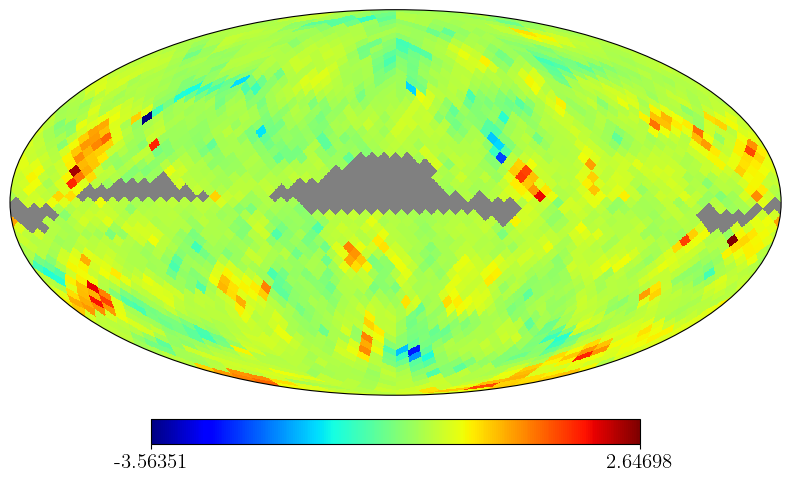

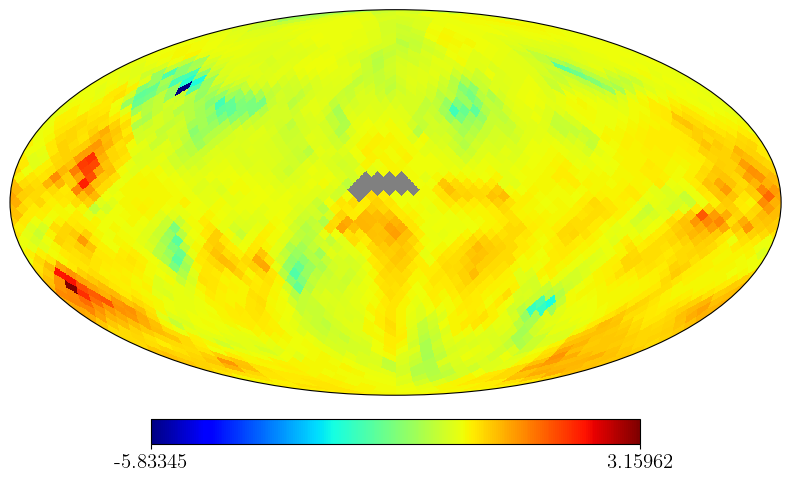

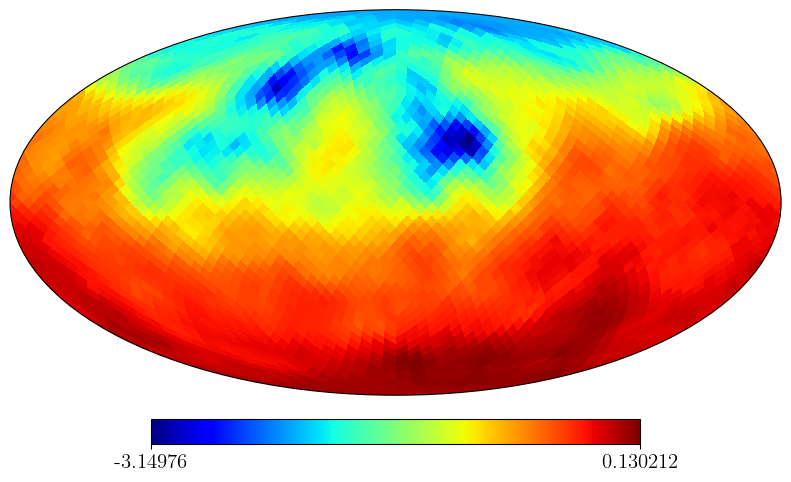

In [ ]:
_mflag = run_inputs.measure_flag.lower()
_series = cleaning_pipeline

for disc_size in [10., 20., 90.]:
    #CMB measure
    cmb_msr    = np.loadtxt(base_path + f"{_series}_cmb_{_mflag}_{disc_size:02}cap.txt")
    #Simulations measure
    sims_msr   = np.loadtxt(base_path + f"{_series}_sims_{_mflag}_{disc_size:02}cap.txt")
    mean_field = np.mean(sims_msr, axis = 0)
    var_msr = np.var(sims_msr, axis = 0)
    # CMB local variance
    cmb_local_msr_map = (cmb_msr - mean_field) / var_msr
    hp.projview(cmb_local_msr_map,
                # title = r"Weighted Local Var map created with ${}^\circ$ discs".format(disc_size),
                cmap = "jet",
                xsize = 1600,
                fontsize = dict(title = 20,
                                cbar_tick_label = 15)
                )
    custom_save_fig(fig = None,
                    fdir = base_path + "plots/",
                    fname = "{}_skewmap{:02}cap".format(cleaning_pipeline, disc_size),
                    do_plt_save = True)
    plt.show()

### Taking ***Stripes*** and computing ***Mean*** to get $LocalVar(\theta)$

In [ ]:
# Common PixMap
dummy_map = cau.dtypes.PixMap.create_dummy(run_inputs.dir_nside)
# Read computed measures
_mflag = run_inputs.measure_flag.lower()
_series = cleaning_pipeline

cmb_directions  = np.loadtxt(base_path + f"{_series}_cmb_{_mflag}_dir.txt", dtype=int)
sims_directions = np.loadtxt(base_path + f"{_series}_sims_{_mflag}_dir.txt", dtype=int)
dir_lat, dir_lon = cau.coords.get_healpix_latlon(run_inputs.dir_nside)

# New settings for taking stripes
run_inputs.geom_flag        = cau.const.STRIPE_FLAG
run_inputs.measure_flag     = cau.const.MEAN_FLAG
run_inputs.stripe_thickness = 10

# We also calculate dipole with healpy fit_dipole routine to see the difference of methods
cmb_dipole_amp  = 0
sims_dipole_amp = np.zeros(run_inputs.max_sim_num)

cmb_cap_dmean2  = np.zeros(len(run_inputs.geom_range))
sims_cap_dmean2 = np.zeros((max_sim_num, len(run_inputs.geom_range)))

for ds_i, disc_size in enumerate(map_disc_sizes):
    cmb_msr    = np.loadtxt(base_path + f"{_series}_cmb_{_mflag}_{disc_size:02}cap.txt")
    sims_msr   = np.loadtxt(base_path + f"{_series}_sims_{_mflag}_{disc_size:02}cap.txt")
    # Find Mean Field
    mean_field = np.mean(sims_msr, axis = 0)
    var_msr = np.var(sims_msr, axis = 0)
    # Set Mask
    dummy_map.mask = np.isnan(cmb_msr)
    # Calculation for CMB
    cmb_data = (cmb_msr - mean_field) / var_msr
    dummy_map.raw_data = cmb_data
    dir_index  = cmb_directions[ds_i]
    plat, plon = dir_lat[dir_index], dir_lon[dir_index]
    dummy_map.change_pole(plat, plon)
    cmb_cap_dmean2 = cau.measure.get_measure(dummy_map, **run_inputs.to_kwargs())
    cmb_dipole_amp = cau.map_utils.get_dipole_amplitude(dummy_map)
    # Calculation for Simulations
    for sim_num in range(run_inputs.max_sim_num):
        sim_data = (sims_msr[sim_num] - mean_field) / var_msr
        dummy_map.raw_data = sim_data
        dir_index  = sims_directions[ds_i, sim_num]
        plat, plon = dir_lat[dir_index], dir_lon[dir_index]
        dummy_map.change_pole(plat, plon)
        sims_cap_dmean2[sim_num] = cau.measure.get_measure(dummy_map, **run_inputs.to_kwargs())
        sims_dipole_amp[sim_num] = cau.map_utils.get_dipole_amplitude(dummy_map)
    
    _stripe_size = run_inputs.stripe_thickness
    f"{_series}_cmb_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt"
    np.savetxt( base_path + f"{_series}_cmb_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt",
                cmb_cap_dmean2,
                comments = str(cmb_dipole_amp))
    np.savetxt( base_path + f"{_series}_sims_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt",
                sims_cap_dmean2,
                comments = str(sims_dipole_amp))

#### Plots of $LocalVar(\theta)$

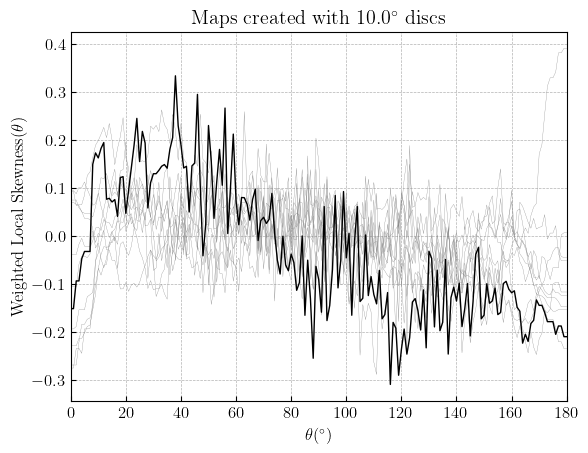

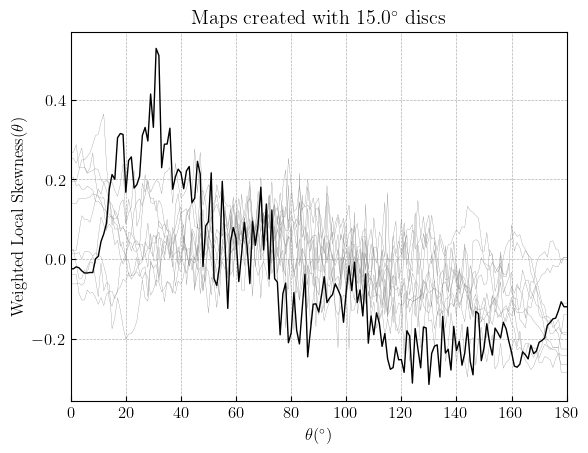

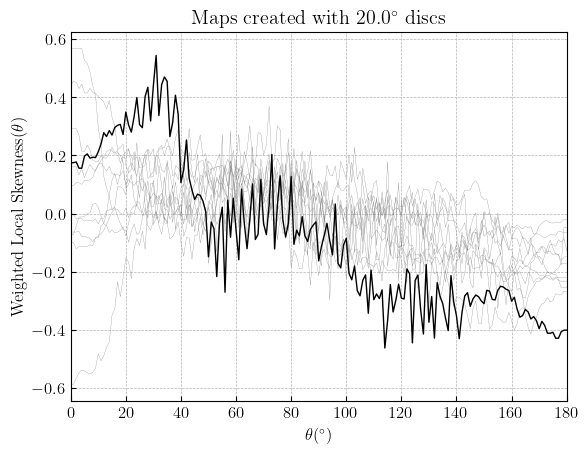

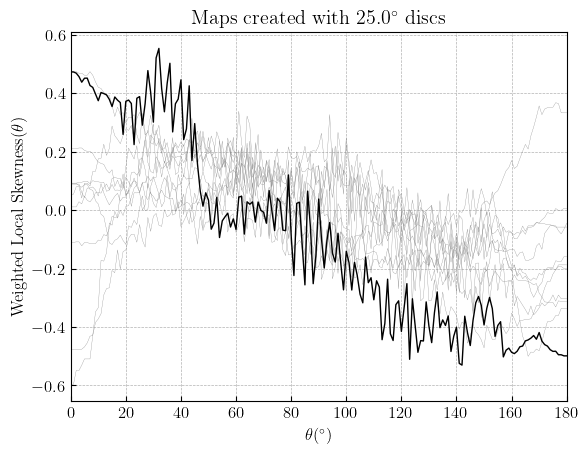

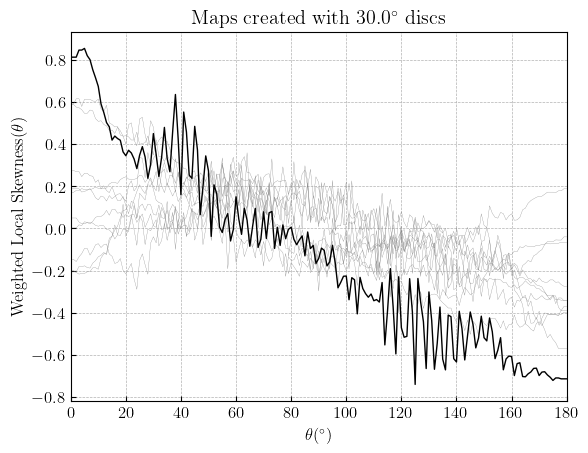

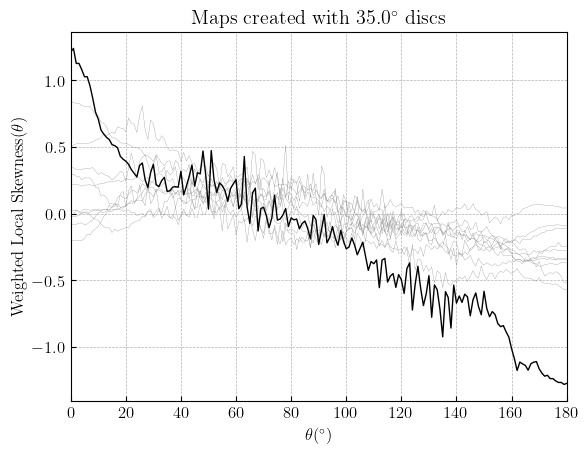

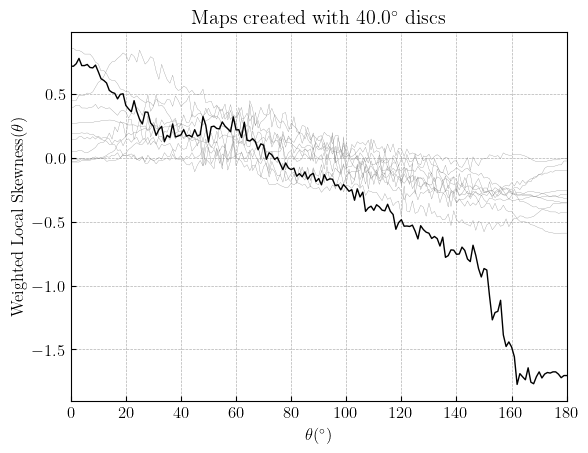

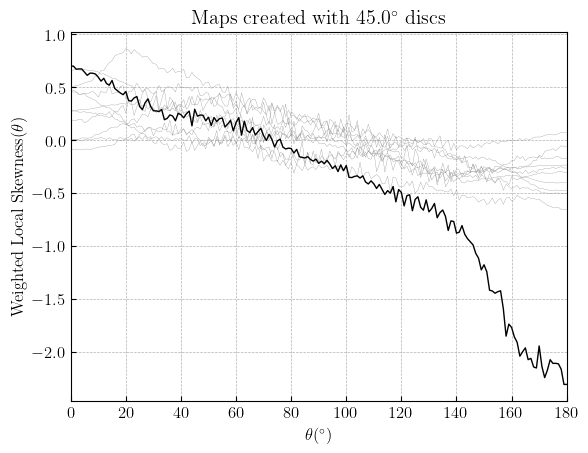

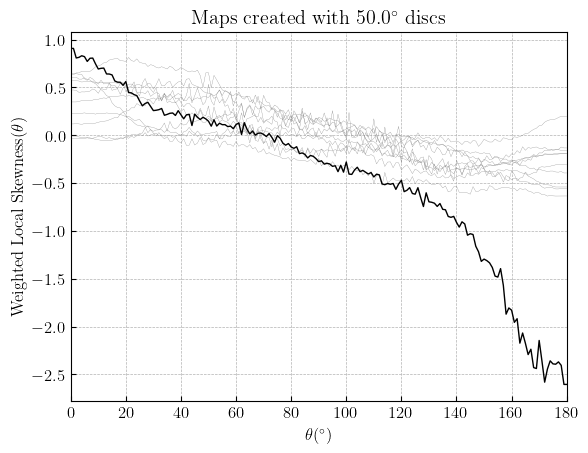

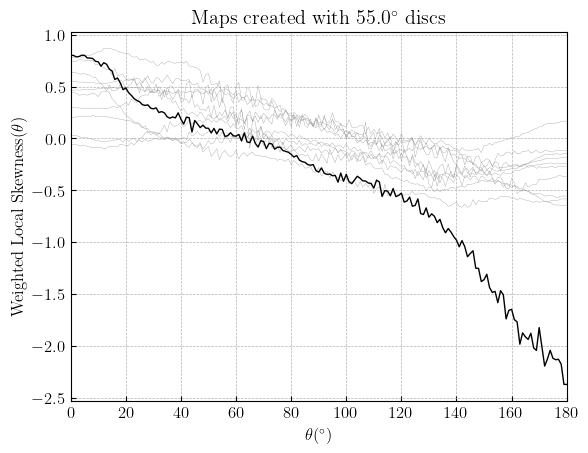

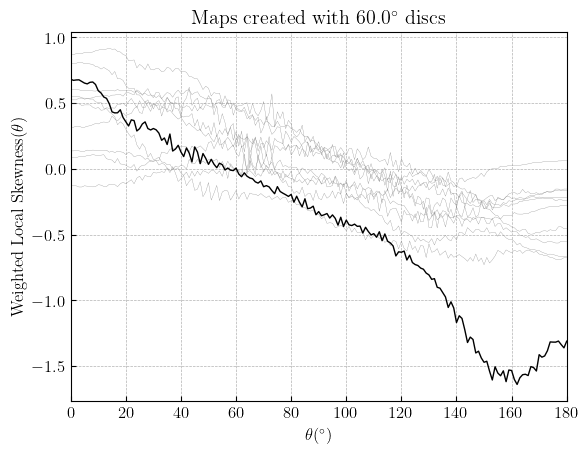

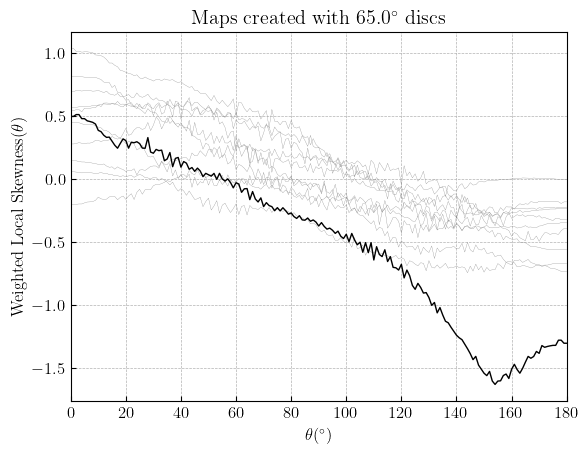

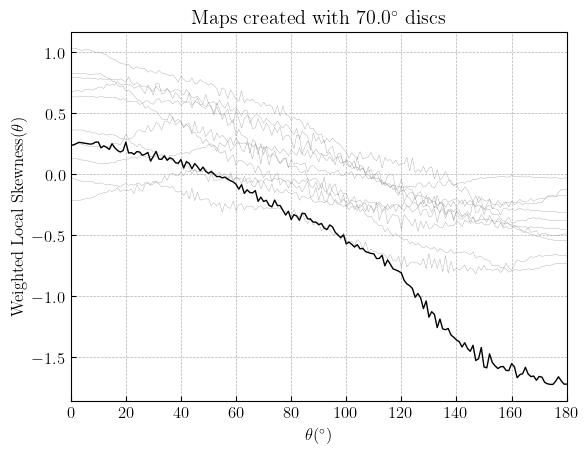

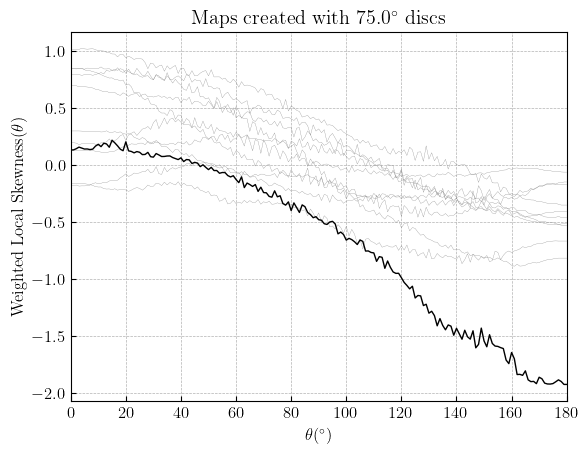

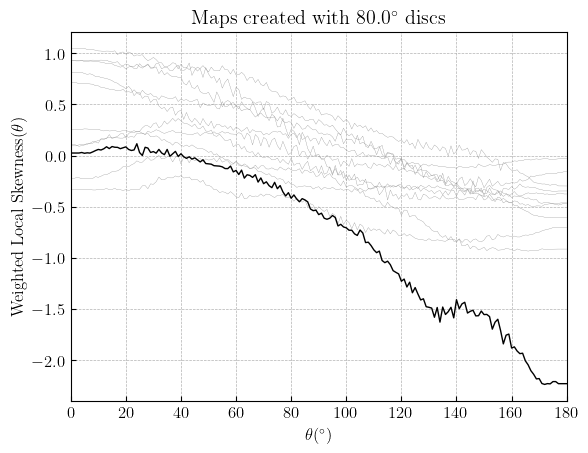

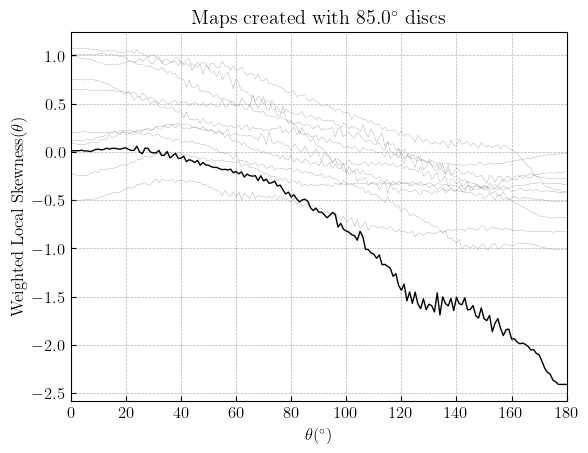

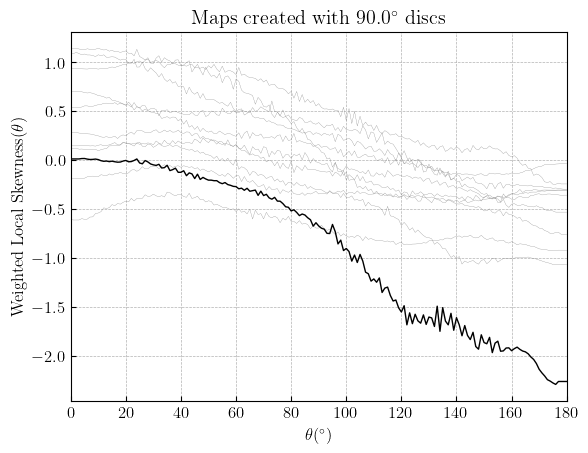

In [ ]:
_mflag = run_inputs.measure_flag.lower()
_series = cleaning_pipeline
_stripe_size = run_inputs.stripe_thickness

with plt.style.context('bmh'):
    for disc_size in map_disc_sizes:
        fig, ax=plt.subplots()
        cmb_measure  = np.loadtxt(base_path + f"{_series}_cmb_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt")
        sims_measure = np.loadtxt(base_path + f"{_series}_sims_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt")
        for i in range(run_inputs.max_sim_num):
            # ax.scatter(run_inputs.geom_range, sims_measure[i],
            #            marker='.', edgecolors='none', linewidth=.1, c='green', alpha=1)
            ax.plot(run_inputs.geom_range, sims_measure[i],
                       linewidth=.2, color='grey')
        ax.plot(run_inputs.geom_range, cmb_measure,
                color='k', linewidth=1)
        ax.set_xlabel(r"$\theta (^\circ)$")
        ax.set_ylabel(r"$\mathrm{Weighted\;Local\;Skewness}(\theta)$")
        ax.set_title(r"Maps created with ${cap_size}^\circ$ discs".format(cap_size = disc_size))
        ax.set_xlim(xmin = 0, xmax = 180)
        ax.set_facecolor('white')
        # Axis colors
        for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
        plt.show()
        custom_save_fig(fig, fdir = base_path + "plots/", fname = "{}_{:02}stripe_{}mean{:02}cap".format(cleaning_pipeline, run_inputs.stripe_thickness, _mflag, disc_size))

### Comparing Dipoles in Two Approaches

#### Plot of dipole comparison

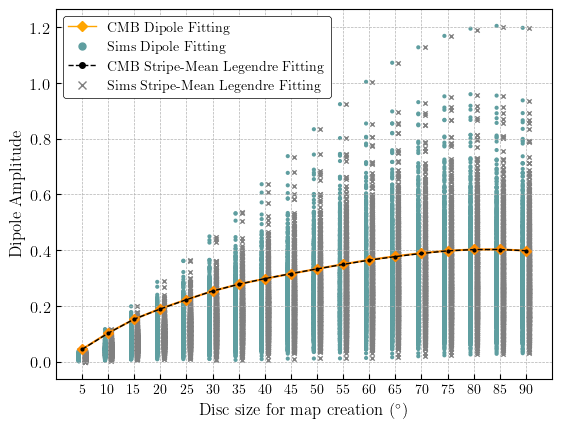

In [ ]:
_theta = np.pi / 180 * run_inputs.geom_range

_map_disc_sizes = cau.stat_utils.get_range(5, 90, 5)

# Akrami2014 dipole amplitude
cmb_dip_amp = np.loadtxt(base_path + "{}_cmb_var_amp.txt".format(cleaning_pipeline))
sims_dip_amp = np.loadtxt(base_path + "{}_sims_var_amp.txt".format(cleaning_pipeline))

# Find Stripe-Method's dipole amplitude
cmb_A1 = np.zeros(len(_map_disc_sizes))
sims_A1 = np.zeros((len(_map_disc_sizes), run_inputs.max_sim_num))

_mflag = run_inputs.measure_flag.lower()
_series = cleaning_pipeline
_stripe_size = run_inputs.stripe_thickness

for ds_i, disc_size in enumerate(_map_disc_sizes):
    cmb_measure  = np.loadtxt(base_path + f"{_series}_cmb_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt")
    sims_measure = np.loadtxt(base_path + f"{_series}_sims_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt")
    # Dipole with stripe-mean Legendre fitting
    for sim_num in range(run_inputs.max_sim_num):
        sims_A1[ds_i,sim_num] = cau.math_utils.get_single_legendre_coef(_theta, sims_measure[sim_num], 1)
    cmb_A1[ds_i] = cau.math_utils.get_single_legendre_coef(_theta, cmb_measure, 1)

with plt.style.context('bmh'):
    x_offset = 0.6
    fig, ax = plt.subplots()
    # Akrami2014 Plot
    for ds_i, disc_size in enumerate(_map_disc_sizes):
        ax.scatter(disc_size * np.ones(run_inputs.max_sim_num) - x_offset, sims_dip_amp[ds_i],
                    marker='.', edgecolors='none', linewidths=.5, c='cadetblue', alpha=1)
    ax.plot(_map_disc_sizes, cmb_dip_amp,
            color='darkorange', marker='D', markersize=5, linewidth=1.5)
    # Stripe-Method Plot
    for ds_i, disc_size in enumerate(_map_disc_sizes):
        ax.scatter(disc_size * np.ones(run_inputs.max_sim_num) + x_offset, sims_A1[ds_i],
                    marker='x', s=10, edgecolors='none', linewidths=1, c='grey', alpha=1)
    ax.plot(_map_disc_sizes, cmb_A1,
            linestyle = '--', marker='o', markersize=2,color='k', linewidth=1)
    
    ax.set_xlabel(r"Disc size for map creation $(^\circ)$")
    ax.set_ylabel(r"Dipole Amplitude")
    # ax.set_title(r"Comparison between stripe-mean Legendre dipole \& Dipole fitting")
    sample_curves = [
        Line2D([0], [0], ls='-',    color='orange',     lw=1, marker='D', markersize=5),
        Line2D([0], [0], ls='none', color='cadetblue',  lw=1, marker='.', markersize=10),
        Line2D([0], [0], ls='--',   color='k',          lw=1, marker='o', markersize=4),
        Line2D([0], [0], ls='none', color='grey',       lw=1, marker='x', markersize=6),
        ]
    ax.legend(  sample_curves,
                [   "CMB Dipole Fitting",
                    "Sims Dipole Fitting",
                    "CMB Stripe-Mean Legendre Fitting",
                    "Sims Stripe-Mean Legendre Fitting"],
                loc=2)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.set_xlim(xmin = 0, xmax = 95)
    ax.set_xticks(_map_disc_sizes)
    ax.set_facecolor('white')
    # Axis colors
    for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
    plt.show()
    custom_save_fig(fig, fdir = base_path + "plots/", fname = "dipole_amplitude_df_Legendre_comparison")

### Multipole Amplitudes

#### Fitting $P_l$ on the LocalVar map

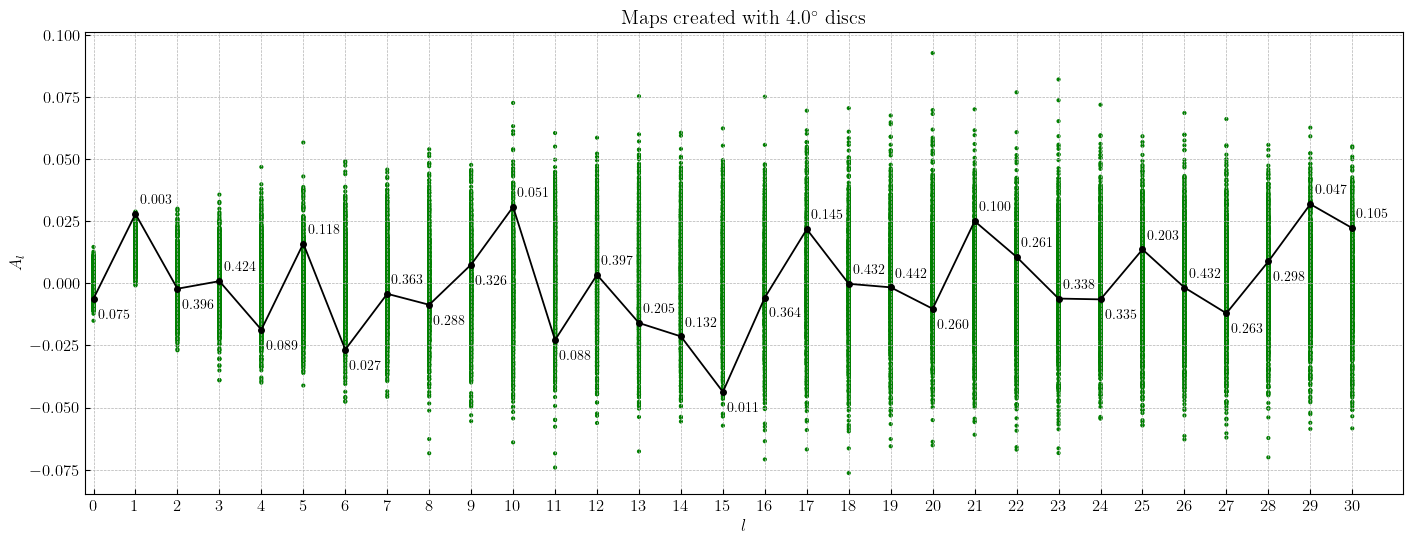

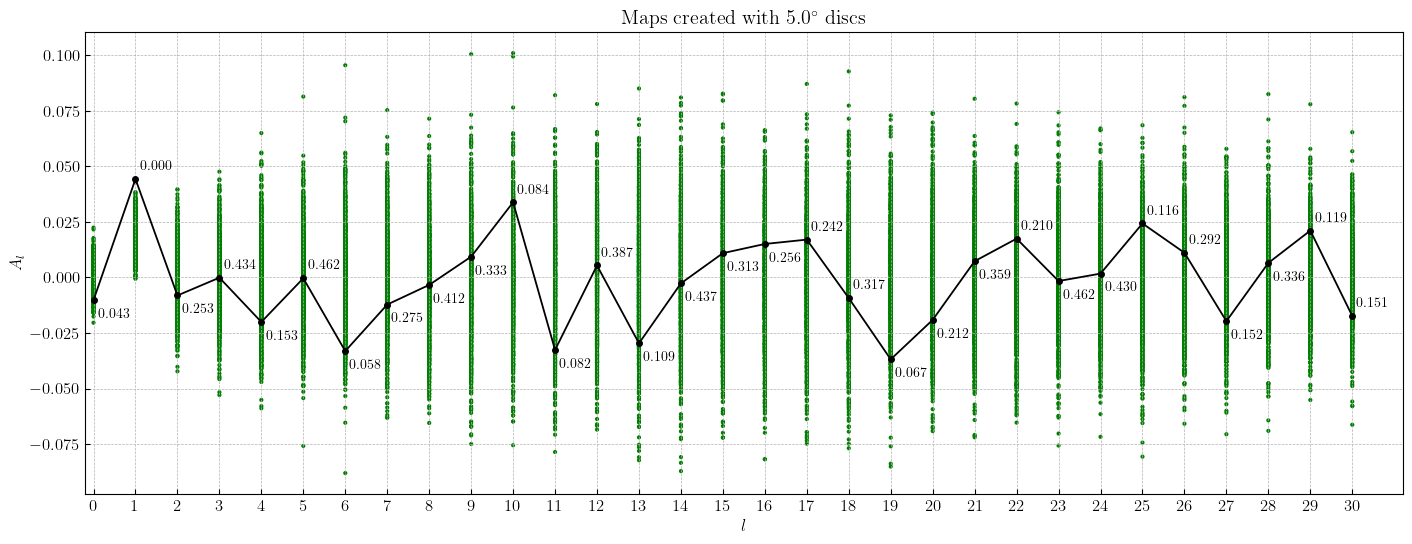

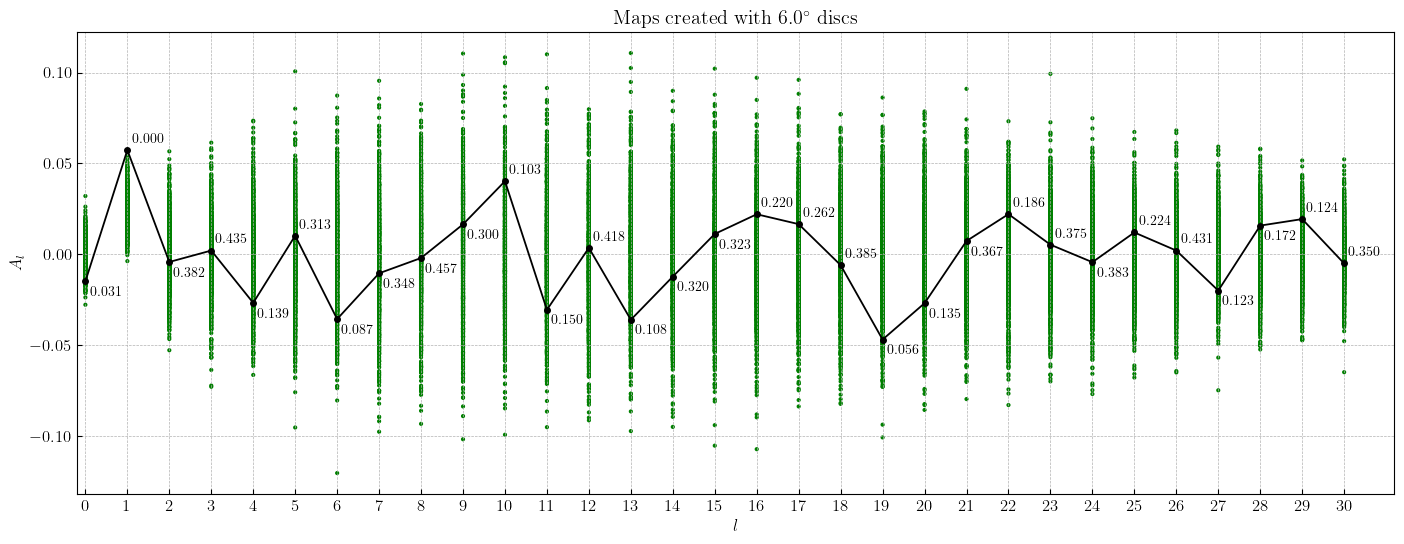

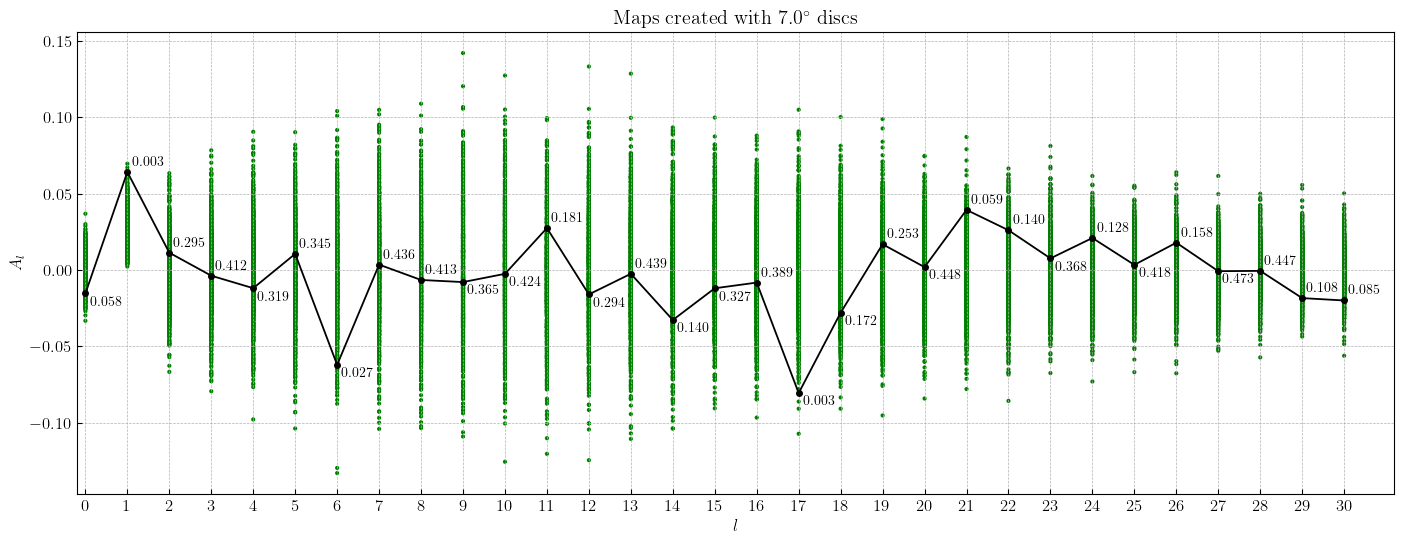

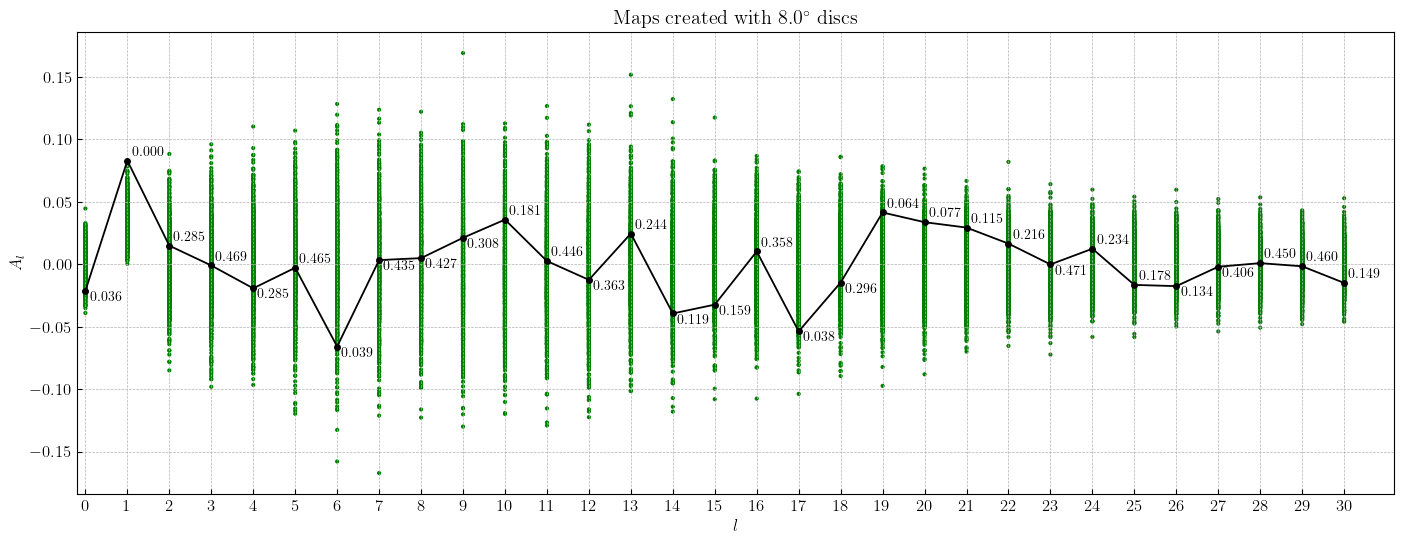

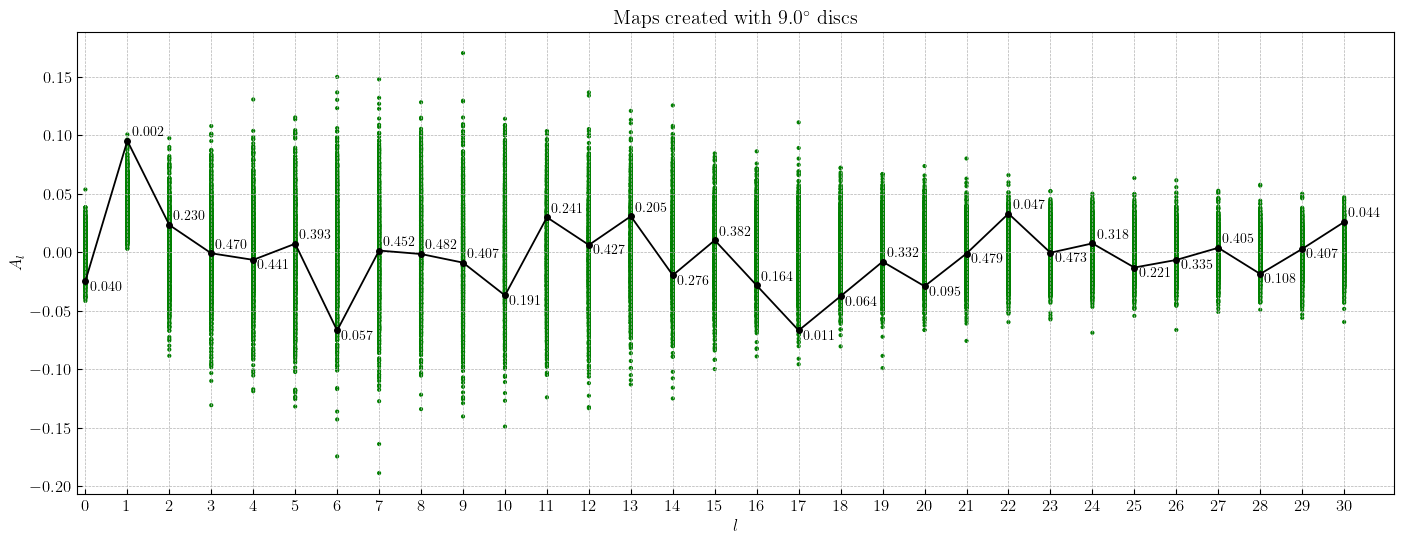

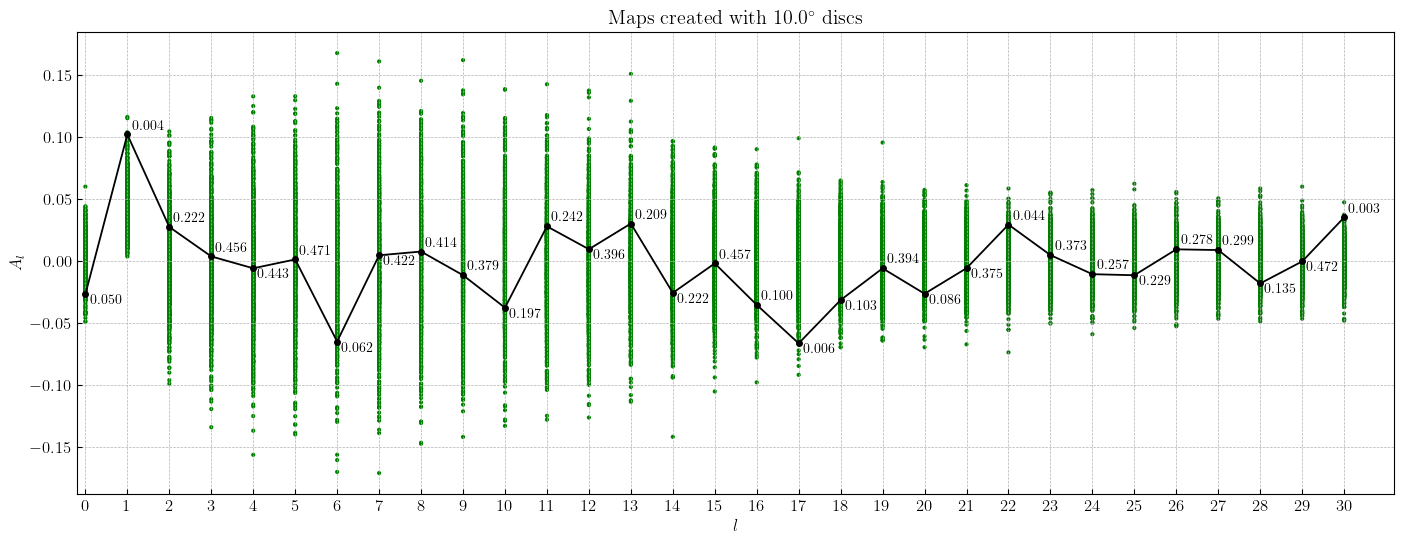

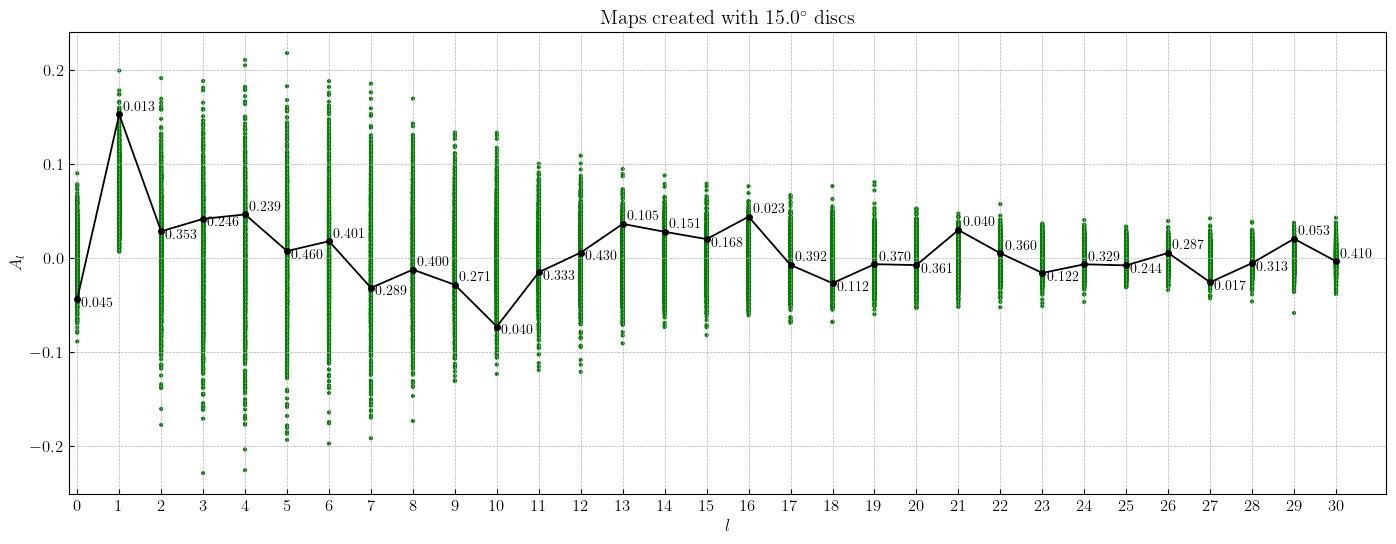

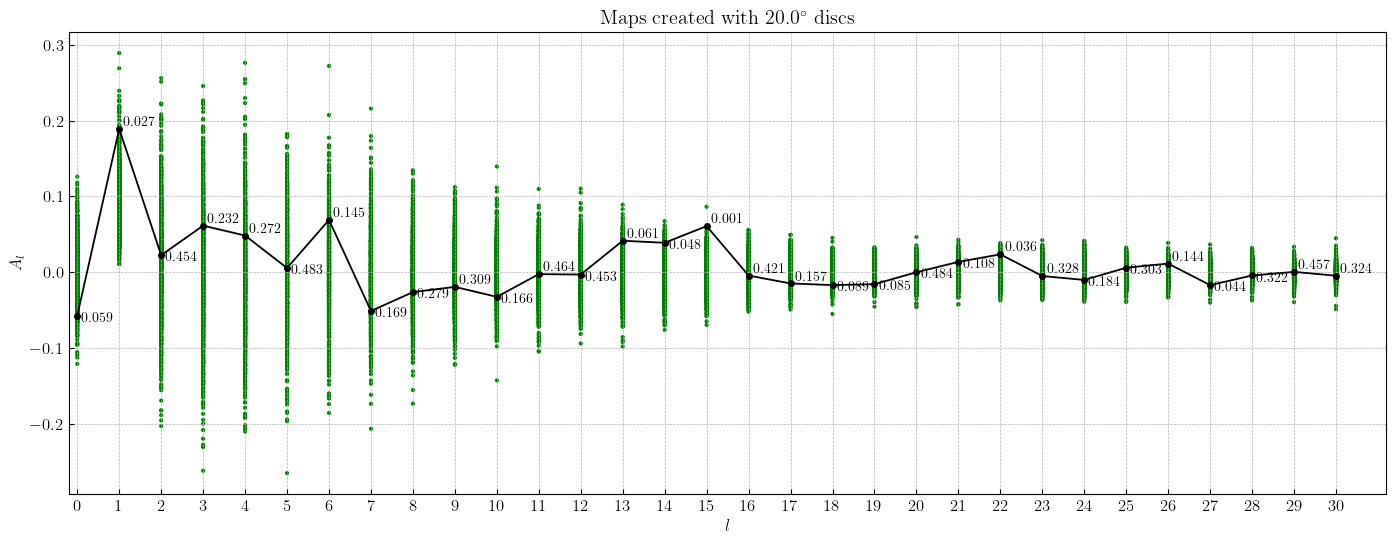

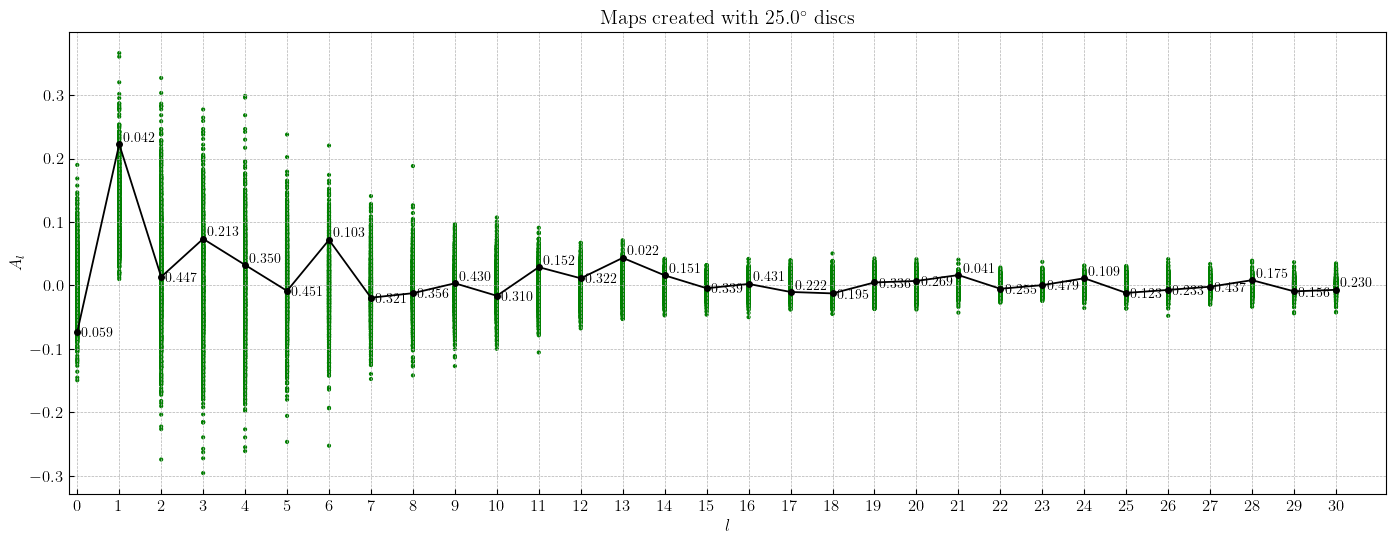

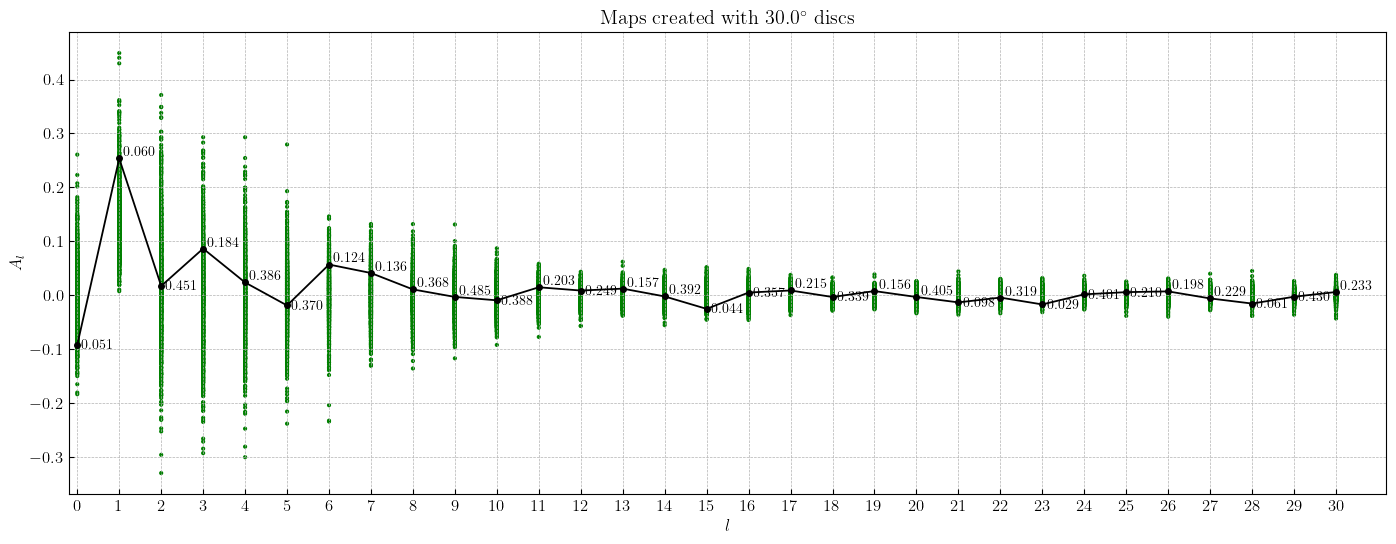

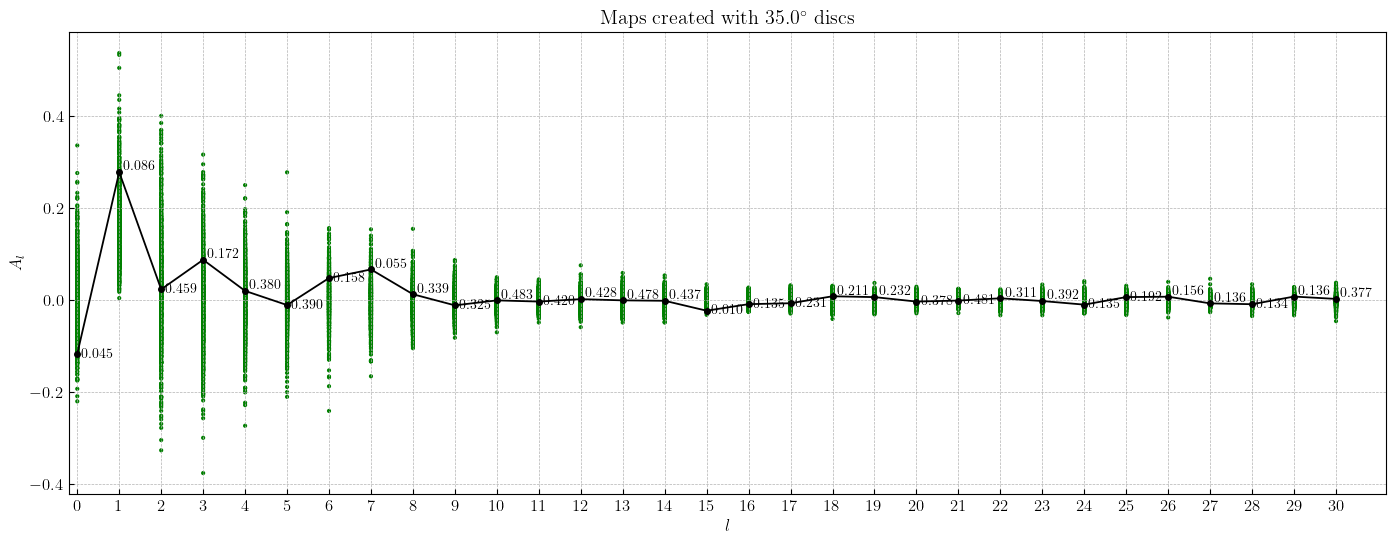

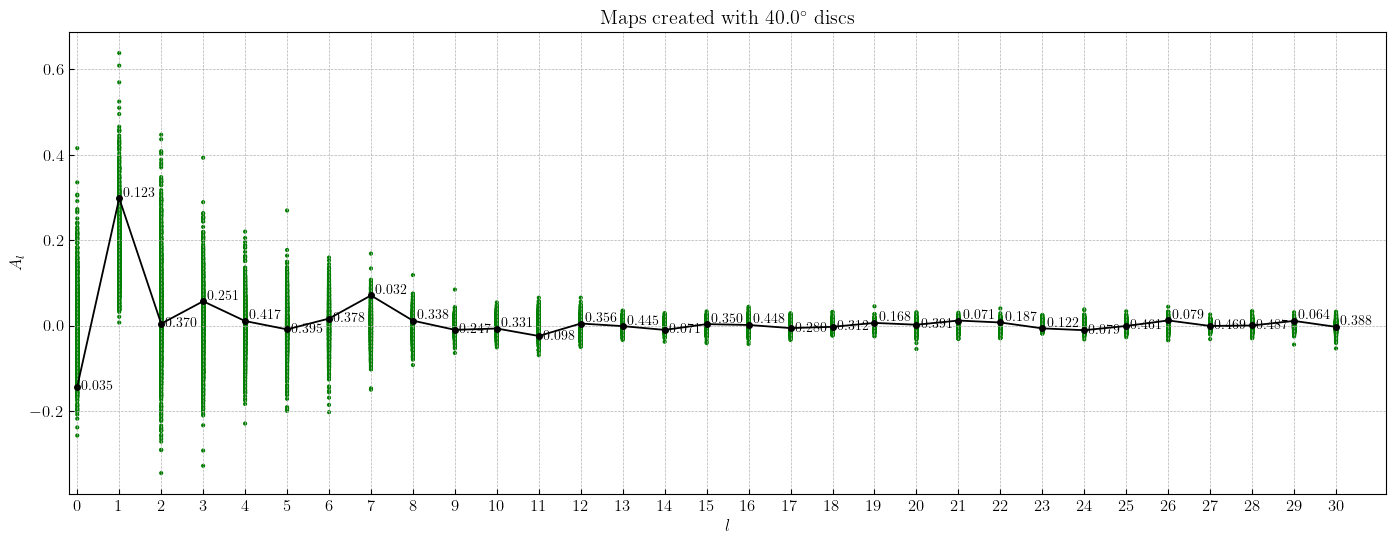

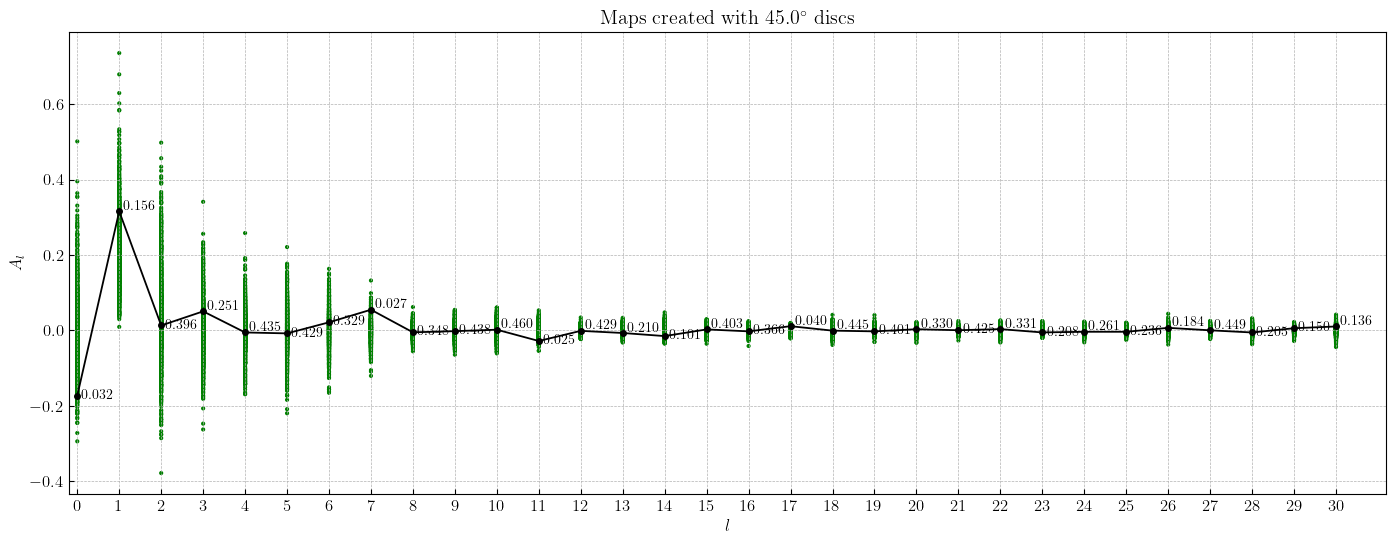

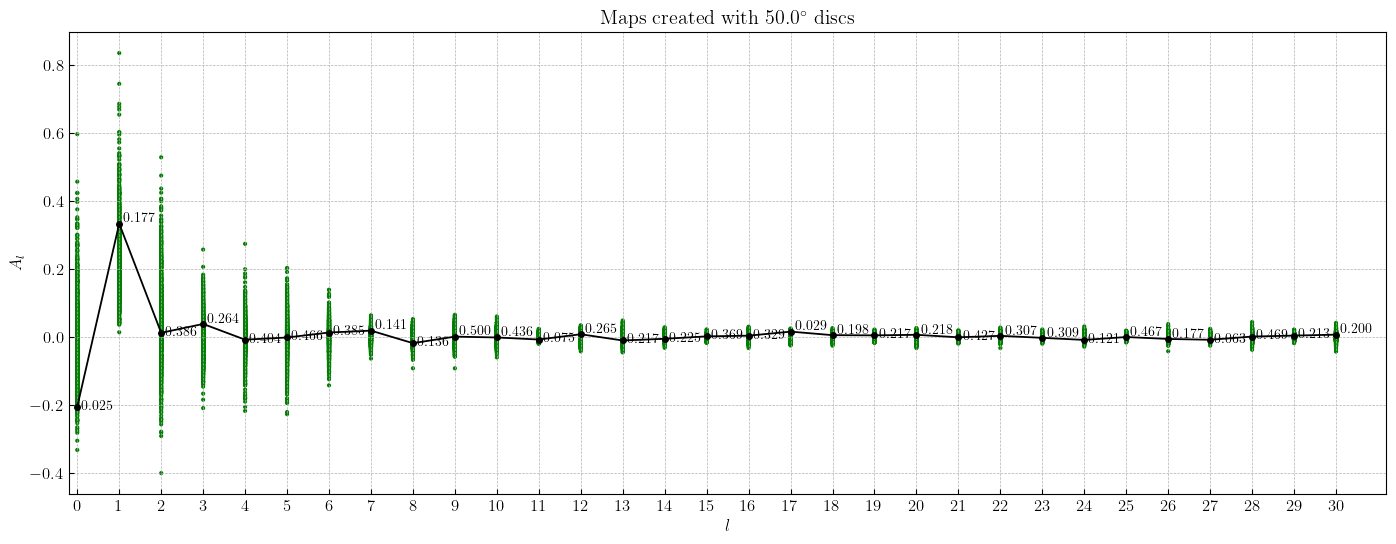

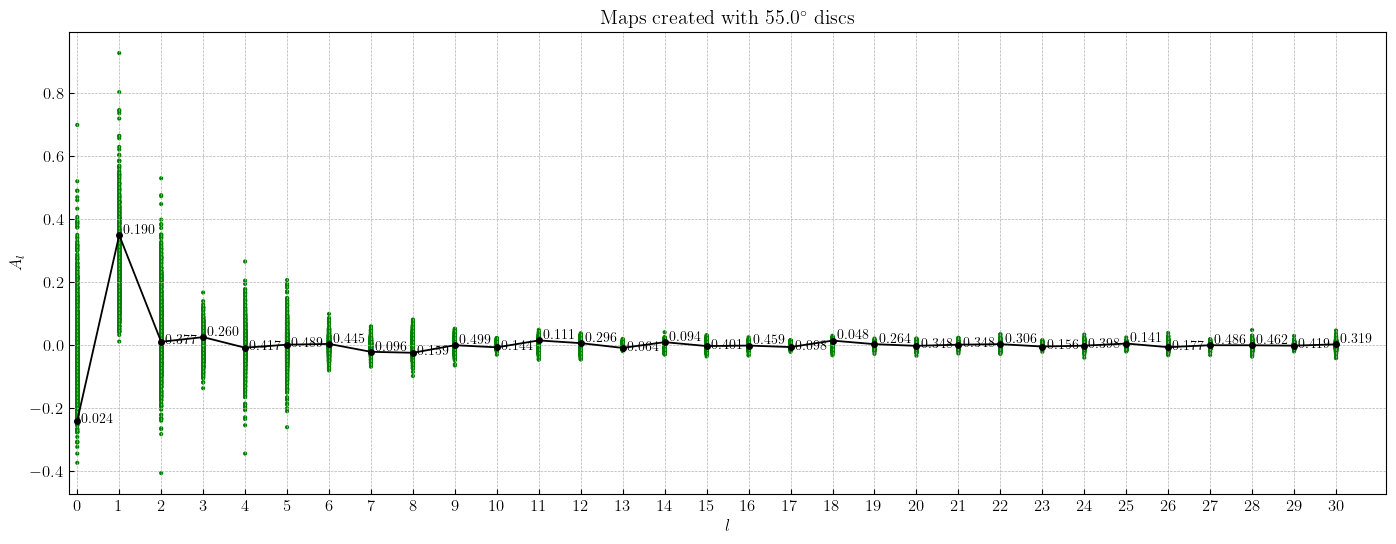

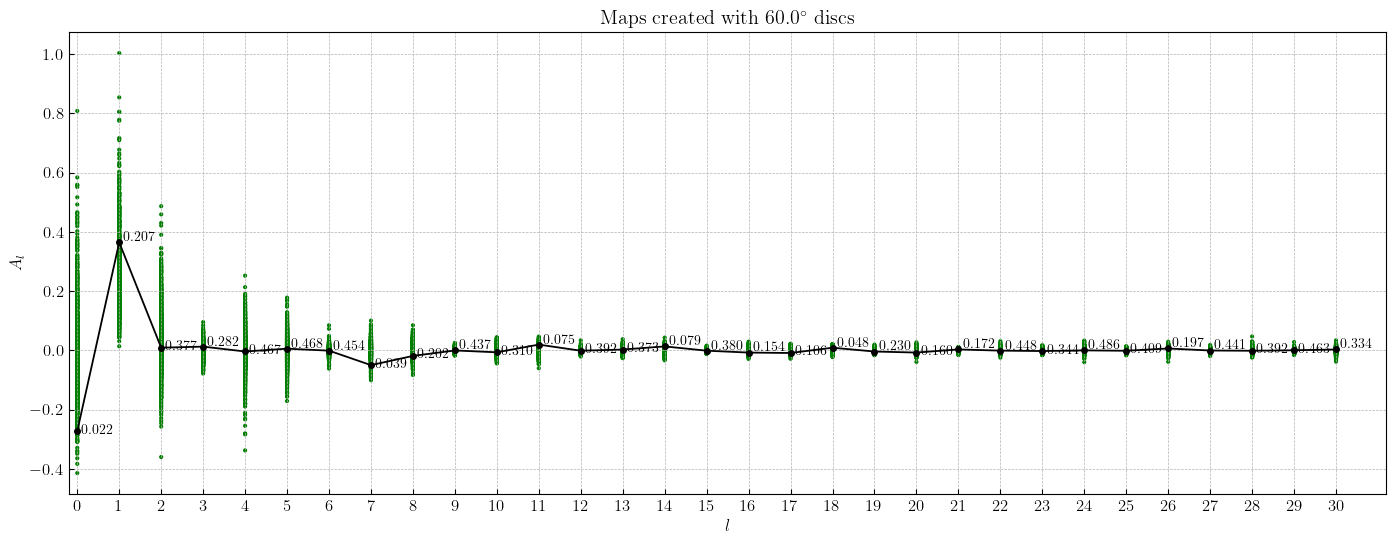

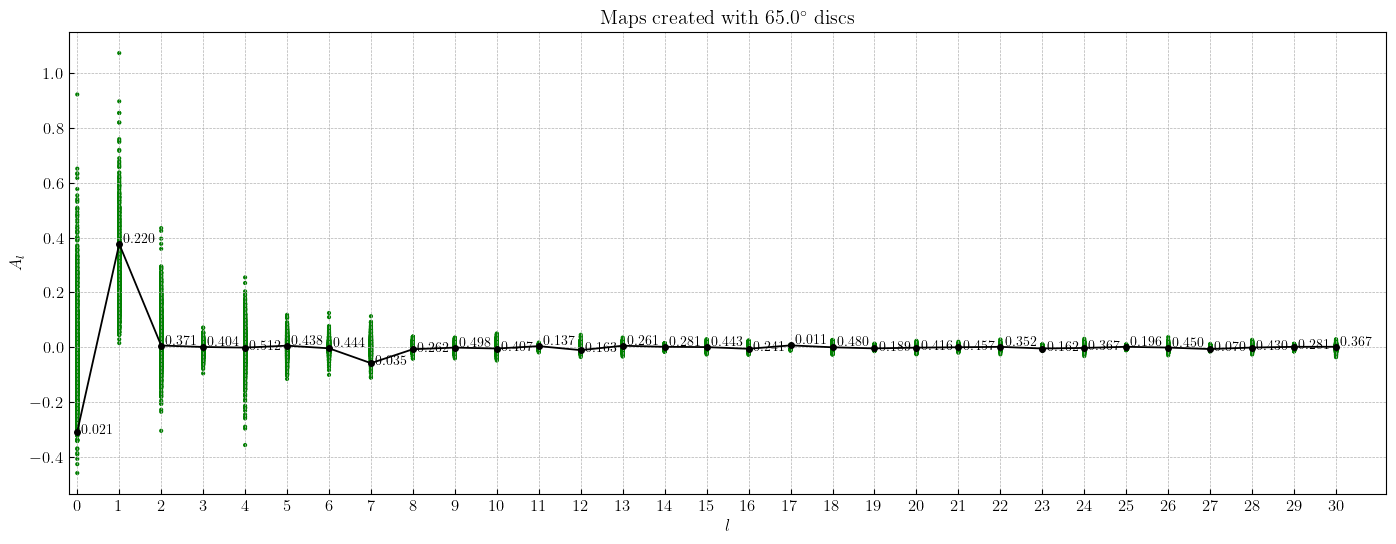

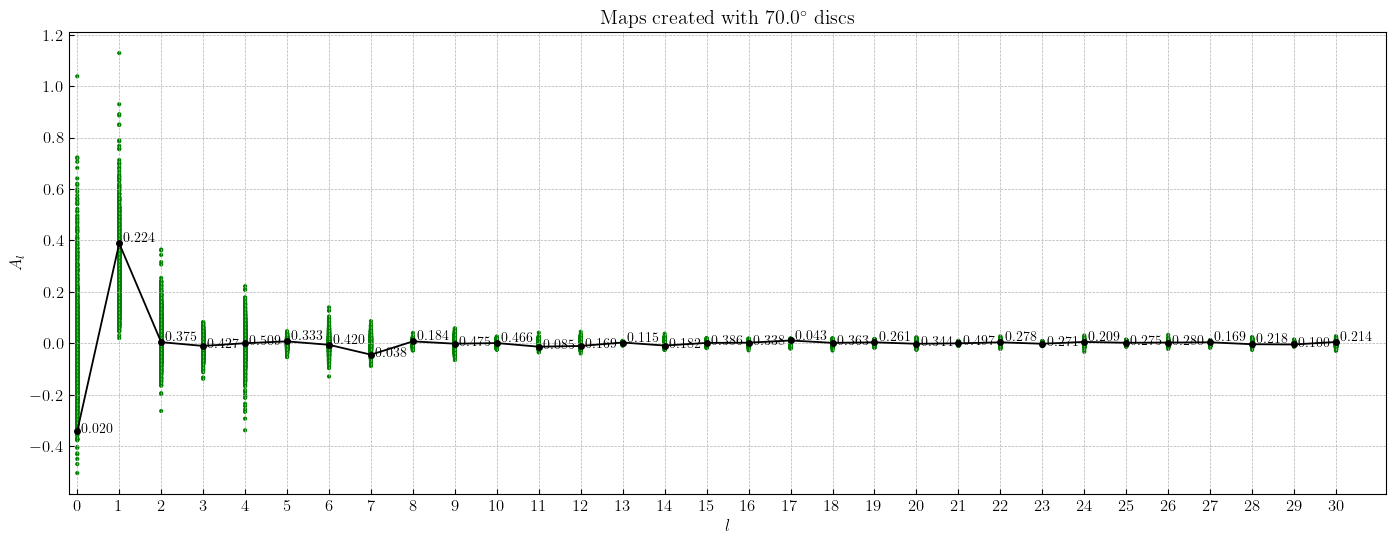

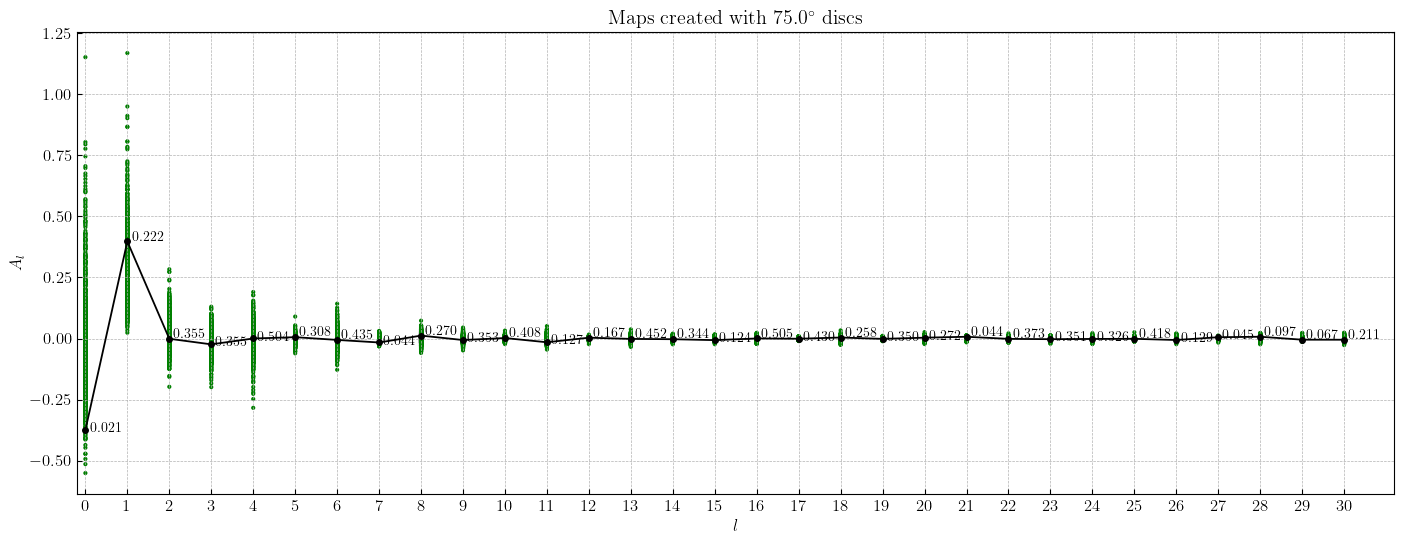

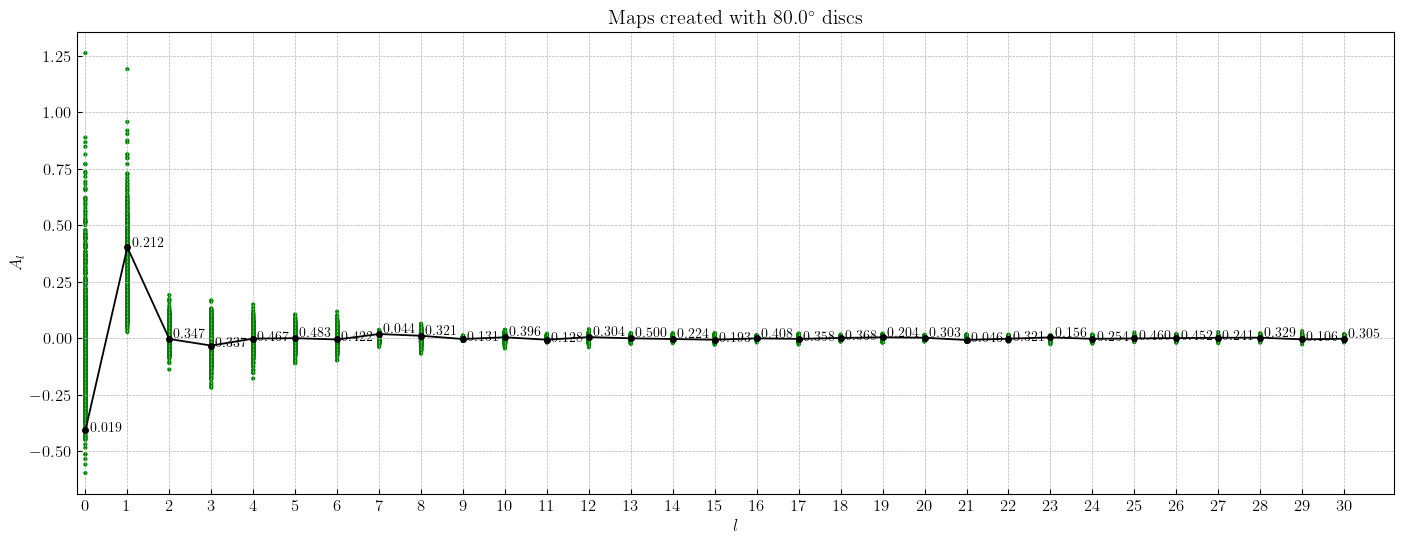

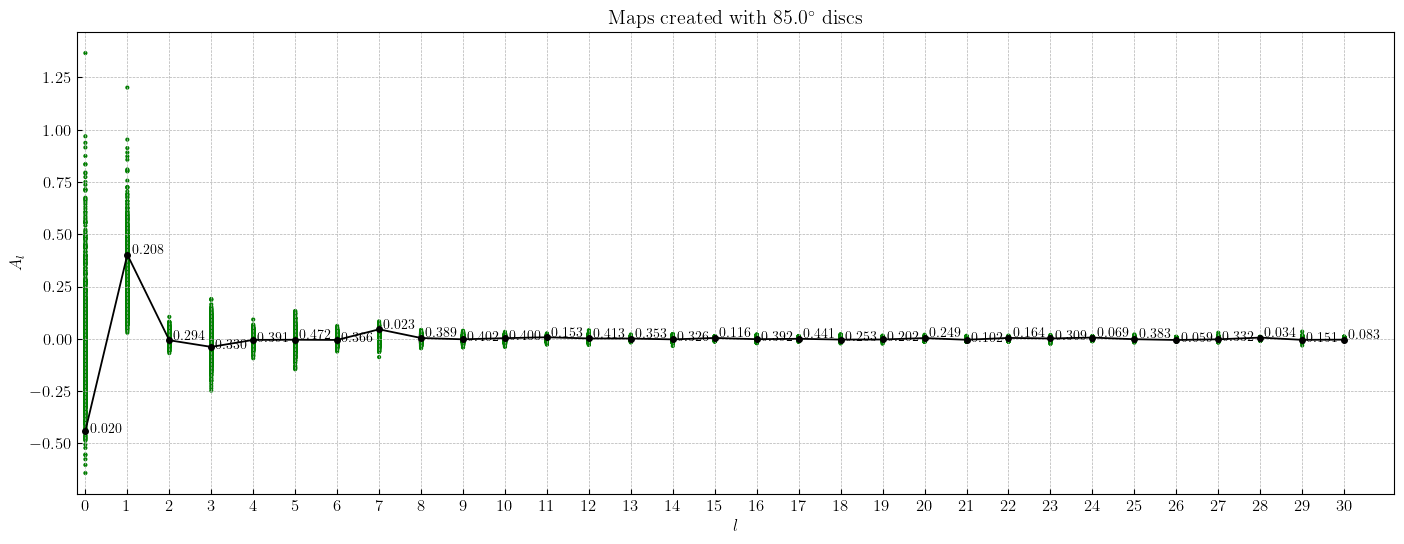

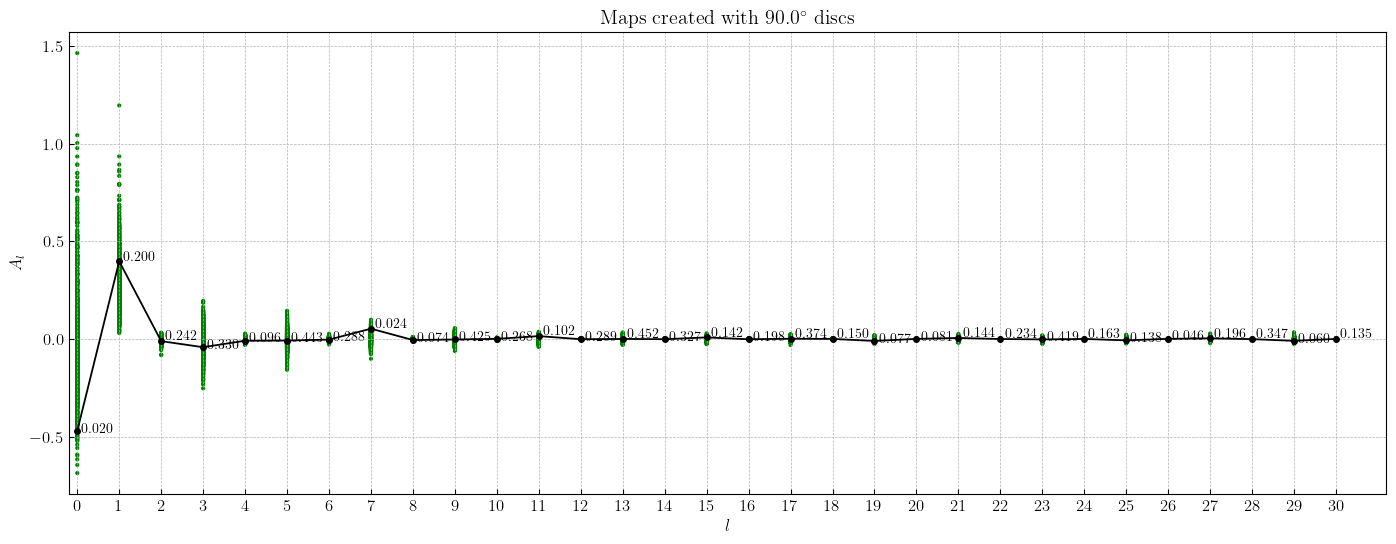

In [ ]:
_theta = np.pi / 180 * run_inputs.geom_range
lrange = np.arange(run_inputs.lmax + 1)
p_values = np.zeros(len(lrange))
sims_a_l = np.zeros((run_inputs.max_sim_num, len(lrange)))


_mflag = run_inputs.measure_flag.lower()
_series = cleaning_pipeline
_stripe_size = run_inputs.stripe_thickness


with plt.style.context('bmh'):
    for disc_size in map_disc_sizes:
        fig, ax=plt.subplots()
        fig.set_size_inches(17,6)
        cmb_measure  = np.loadtxt(base_path + f"{_series}_cmb_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt")
        sims_measure = np.loadtxt(base_path + f"{_series}_sims_{_stripe_size:02}stripe_{_mflag}mean_{disc_size:02}cap.txt")

        # Calculate A_l's
        cmb_a_l = cau.math_utils.get_all_legendre_coefs(_theta, cmb_measure, run_inputs.lmax)
        for sim_num in range(run_inputs.max_sim_num):
            sims_a_l[sim_num] = cau.math_utils.get_all_legendre_coefs(_theta, sims_measure[sim_num], run_inputs.lmax)
        # Calculate P-values
        a_l_mean = np.nanmean(sims_a_l, axis=0)
        for ell in lrange:
            if cmb_a_l[ell] > a_l_mean[ell]:
                p_values[ell] = np.sum(sims_a_l[:, ell] >= cmb_a_l[ell]) / run_inputs.max_sim_num
            else:
                p_values[ell] = np.sum(sims_a_l[:, ell] < cmb_a_l[ell]) / run_inputs.max_sim_num
        
        # Plot
        for sim_num in range(run_inputs.max_sim_num):
            ax.scatter(lrange, sims_a_l[sim_num],
                       marker='.', edgecolors='none', linewidths=.5, c='green', alpha=1)
        
        # a_l_max = np.nanmax(sims_a_l, axis=0)
        for ell in lrange:
            y_plus_offset = 0.004
            y_minus_offset = 0.008
            if ell < len(lrange) - 1 and cmb_a_l[ell + 1] > cmb_a_l[ell]:
                ypos = cmb_a_l[ell] - y_minus_offset
            else:
                ypos = cmb_a_l[ell] + y_plus_offset
            ax.text(x=ell + 0.1, y = ypos, s = "{:0.3f}".format(p_values[ell]))

        ax.plot(lrange, cmb_a_l,
                color='k', linewidth=1.3, marker='o', markersize=4)
        
        ax.set_xlabel(r"$l$")
        ax.set_ylabel(r"$A_l$")
        ax.set_title(r"Maps created with ${cap_size}^\circ$ discs".format(cap_size = disc_size))
        ax.set_xlim(xmin = 0 - 0.2, xmax = run_inputs.lmax + 1 + 0.2)
        ax.set_xticks(lrange)
        # ax.set_aspect(100)
        ax.set_facecolor('white')
        # Axis colors
        for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
        plt.show()
        custom_save_fig(fig, fdir = base_path + "plots/", fname = "{}_{:02}stripe_{}mean_a_l_{:02}cap".format(cleaning_pipeline, run_inputs.stripe_thickness, _mflag, disc_size))
        
        np.savetxt(base_path + "{}_{:02}stripe_{}mean_cmb_a_l_{:02}cap.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, _mflag, disc_size), cmb_a_l)
        np.savetxt(base_path + "{}_{:02}stripe_{}mean_sims_a_l_{:02}cap.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, _mflag, disc_size), sims_a_l)

### Computing Cap Measures

In [ ]:
run_inputs.geom_flag        = cau.const.CAP_FLAG
run_inputs.measure_flag     = cau.const.D_MEAN2_FLAG

# Common PixMap
dummy_map = cau.dtypes.PixMap.create_dummy(run_inputs.dir_nside)

cmb_directions  = np.loadtxt(base_path + "{}_cmb_var_dir.txt".format(cleaning_pipeline), dtype=int)
sims_directions = np.loadtxt(base_path + "{}_sims_var_dir.txt".format(cleaning_pipeline), dtype=int)
dir_lat, dir_lon = cau.coords.get_healpix_latlon(run_inputs.dir_nside)

cmb_cap_dmean2  = np.zeros(len(run_inputs.geom_range))
sims_cap_dmean2 = np.zeros((max_sim_num, len(run_inputs.geom_range)))

for ds_i, disc_size in enumerate(map_disc_sizes):
    cmb_msr    = np.loadtxt(base_path + "{}_cmb_var_{:02}cap.txt".format(cleaning_pipeline, disc_size))
    sims_msr   = np.loadtxt(base_path + "{}_sims_var_{:02}cap.txt".format(cleaning_pipeline, disc_size))
    # Find Mean Field
    mean_field = np.mean(sims_msr, axis = 0)
    var_msr = np.var(sims_msr, axis = 0)
    # Set Mask
    dummy_map.mask = np.isnan(cmb_msr)
    # Calculation for CMB
    cmb_data = (cmb_msr - mean_field) / var_msr
    dummy_map.raw_data = cmb_data
    dir_index  = cmb_directions[ds_i]
    plat, plon = dir_lat[dir_index], dir_lon[dir_index]
    dummy_map.change_pole(plat, plon)
    cmb_cap_dmean2 = cau.measure.get_measure(dummy_map, **run_inputs.to_kwargs())
    # Calculation for Simulations
    for sim_num in range(run_inputs.max_sim_num):
        sim_data = (sims_msr[sim_num] - mean_field) / var_msr
        dummy_map.raw_data = sim_data
        dir_index  = sims_directions[ds_i, sim_num]
        plat, plon = dir_lat[dir_index], dir_lon[dir_index]
        dummy_map.change_pole(plat, plon)
        sims_cap_dmean2[sim_num] = cau.measure.get_measure(dummy_map, **run_inputs.to_kwargs())
    
    np.savetxt( base_path + "{}_cmb_cap_dvarmean2_{:02}cap.txt".format(cleaning_pipeline, disc_size),
                cmb_cap_dmean2)
    np.savetxt( base_path + "{}_sims_cap_dvarmean2_{:02}cap.txt".format(cleaning_pipeline, disc_size),
                sims_cap_dmean2)

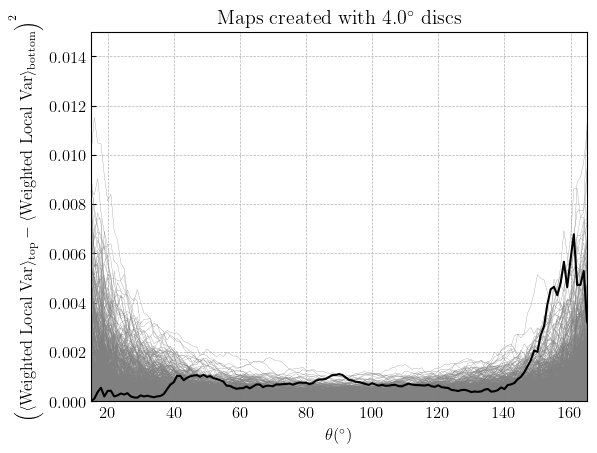

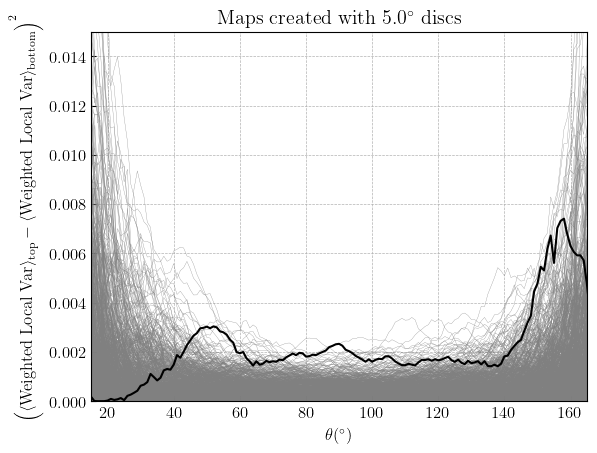

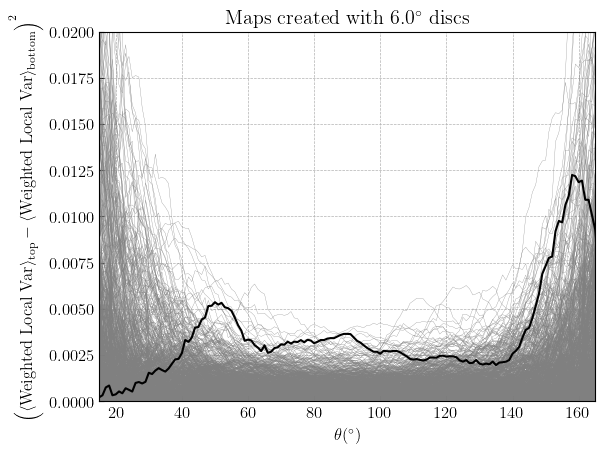

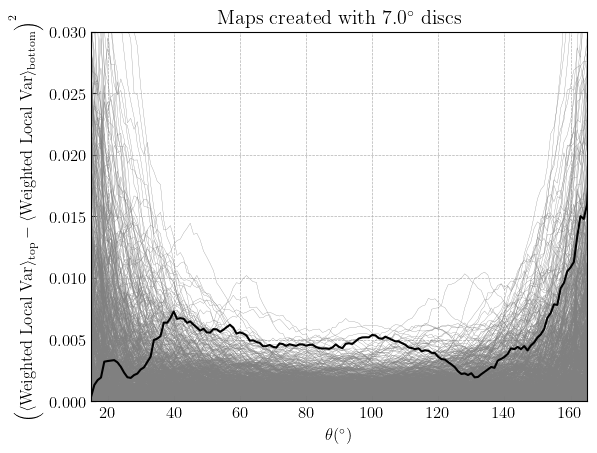

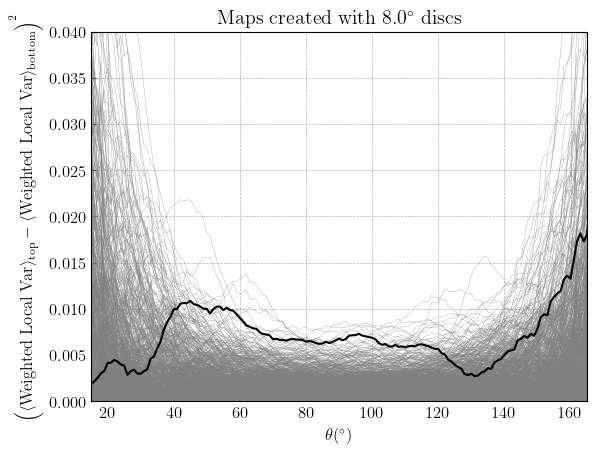

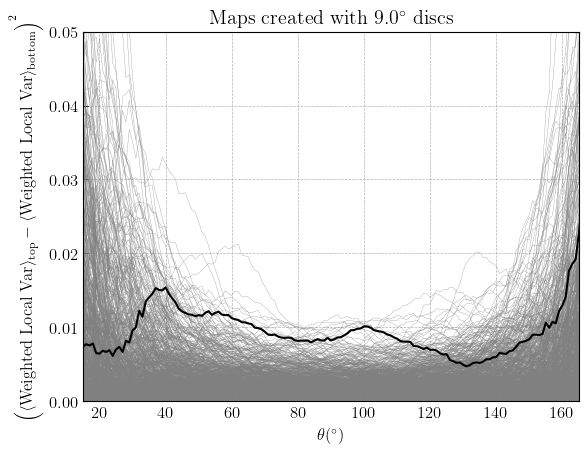

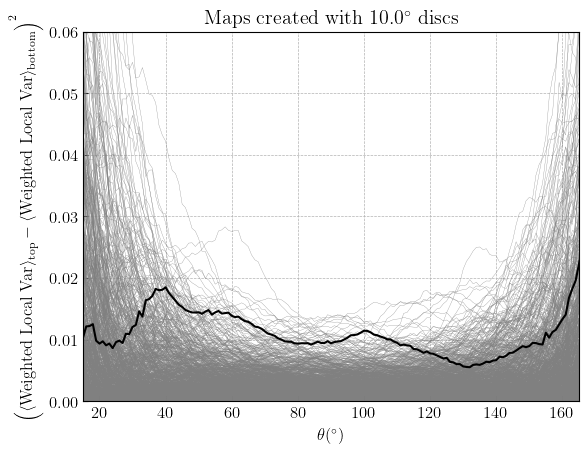

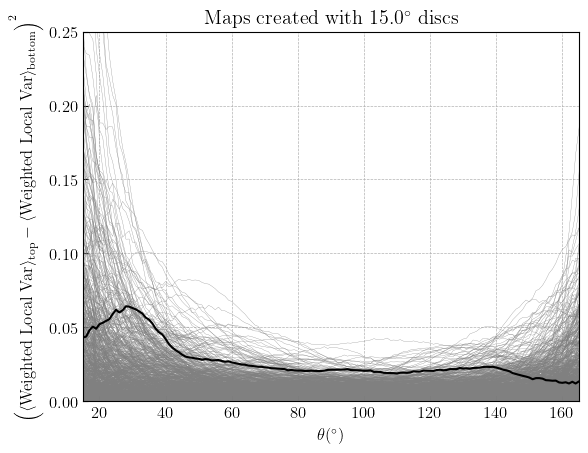

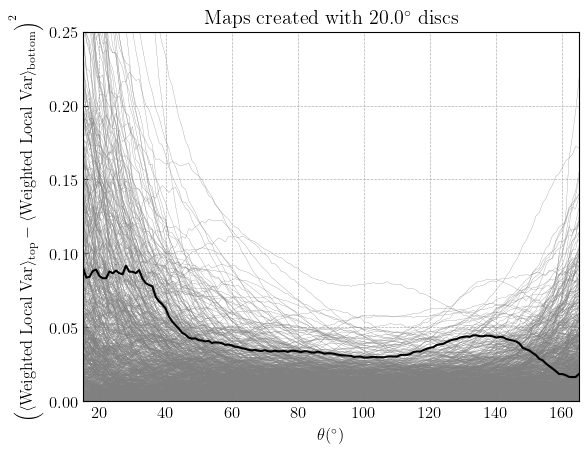

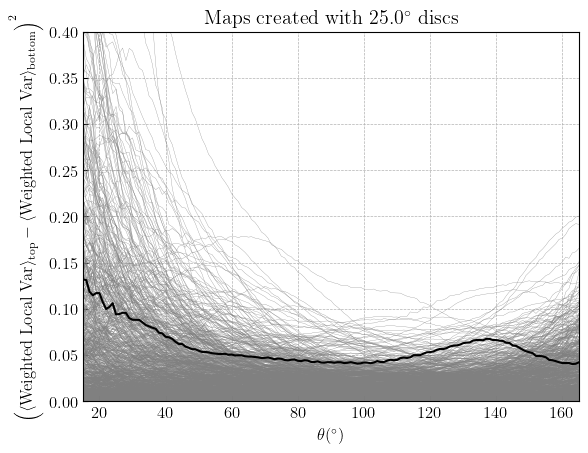

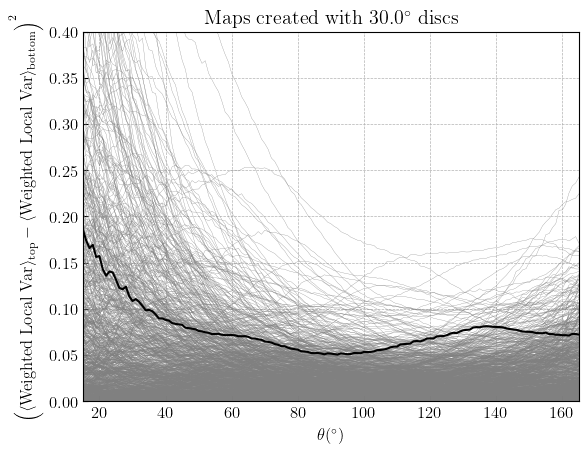

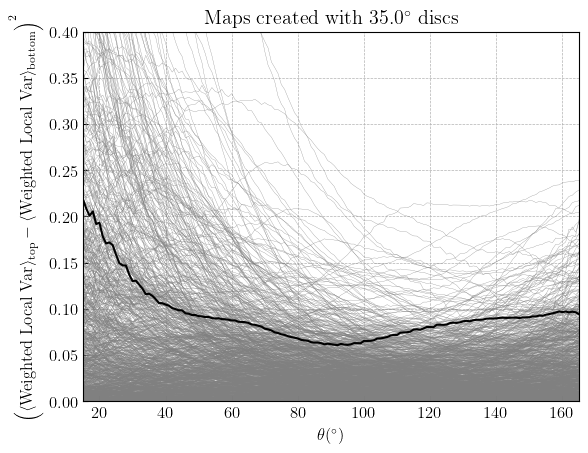

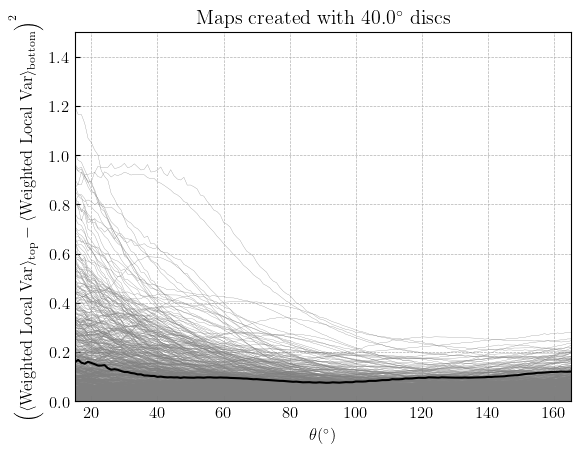

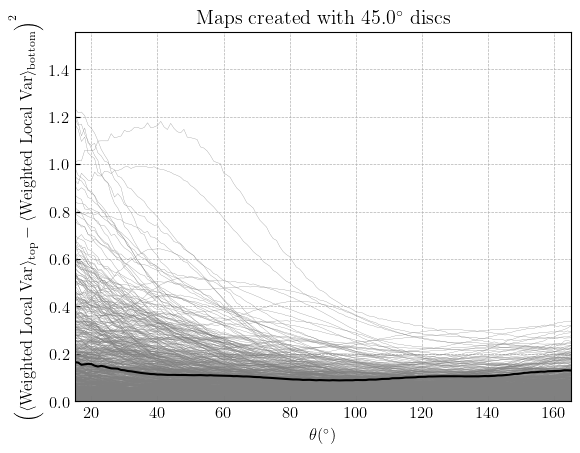

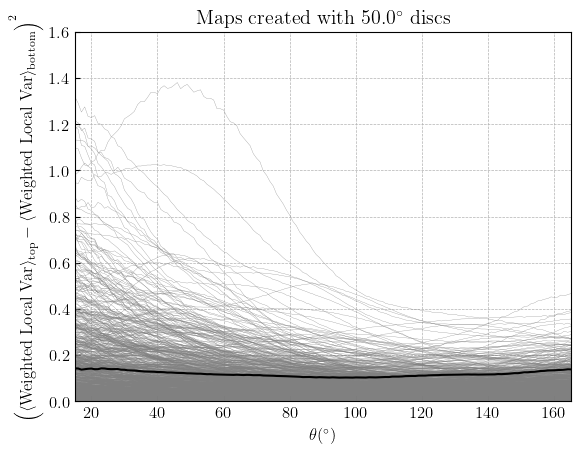

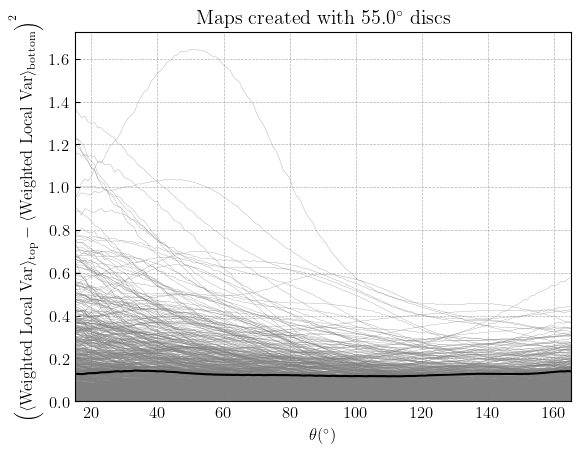

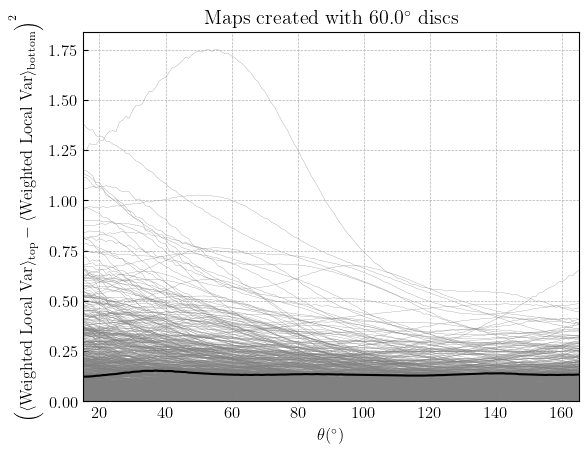

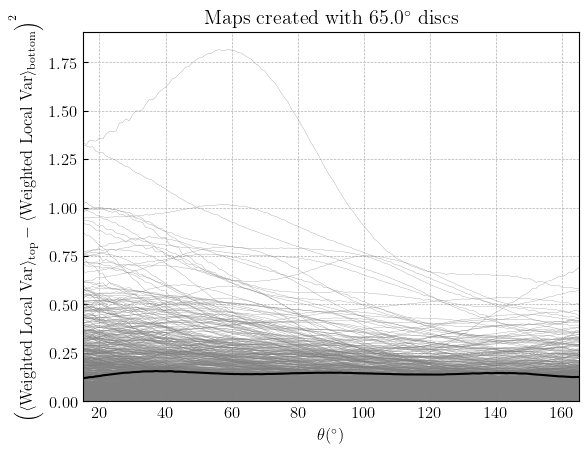

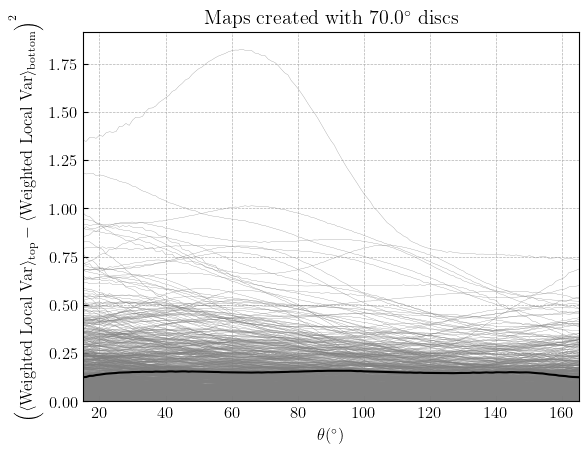

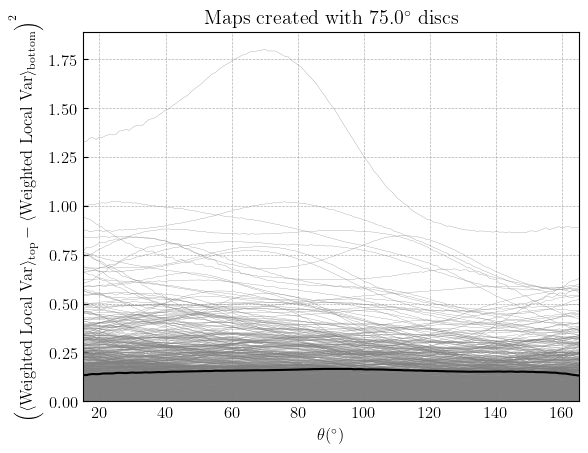

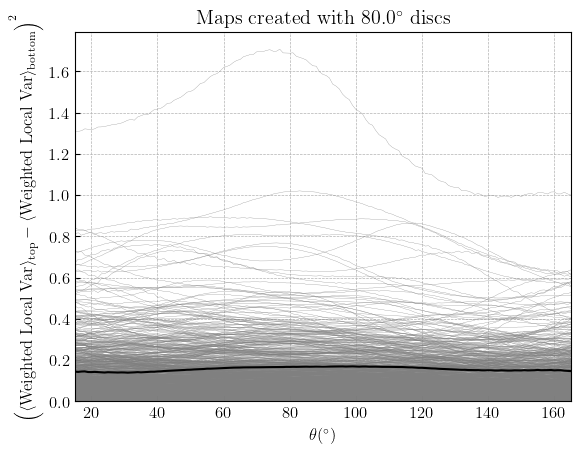

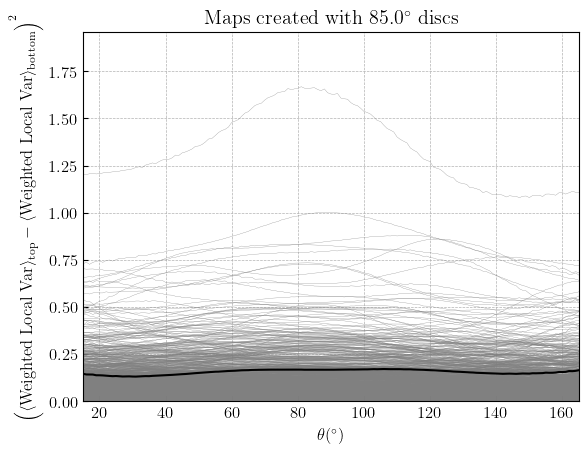

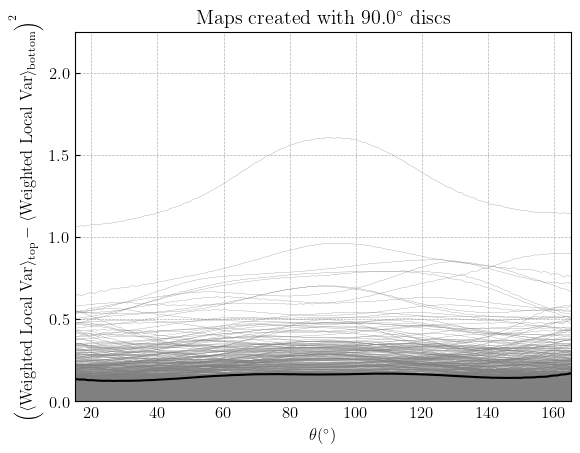

In [7]:
ymax_dict = {
    4:  0.015,
    5:  0.015,
    6:  0.02,
    7:  0.03,
    8:  0.04,
    9:  0.05,
    10: 0.06,
    15: 0.25,
    20: 0.25,
    25: 0.4,
    30: 0.4,
    35: 0.4,
}

with plt.style.context('bmh'):
    for disc_size in map_disc_sizes:
        fig, ax=plt.subplots()
        cmb_measure  = np.loadtxt(base_path + "{}_cmb_cap_dvarmean2_{:02}cap.txt".format(cleaning_pipeline, disc_size))
        sims_measure = np.loadtxt(base_path + "{}_sims_cap_dvarmean2_{:02}cap.txt".format(cleaning_pipeline, disc_size))
        for i in range(run_inputs.max_sim_num):
            ax.plot(run_inputs.geom_range, sims_measure[i],
                    linewidth=.2, color='grey')
        ax.plot(run_inputs.geom_range, cmb_measure,
                color='k', linewidth=1.5)
        ax.set_xlabel(r"$\theta (^\circ)$")
        ax.set_ylabel(r"$\bigg(\langle \mathrm{Weighted\;Local\;Var}\rangle_{\mathrm{top}} - \langle \mathrm{Weighted\;Local\;Var}\rangle_{\mathrm{bottom}}\bigg)^2$")
        ax.set_title(r"Maps created with ${cap_size}^\circ$ discs".format(cap_size = disc_size))
        ax.set_xlim(xmin = 15, xmax = 165)
        ax.set_ylim(ymin = 0)
        if disc_size in ymax_dict.keys():
            ax.set_ylim(ymax = ymax_dict[disc_size])
        ax.set_facecolor('white')
        # Axis colors
        for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
        plt.show()
        custom_save_fig(fig, fdir = base_path + "plots/", fname = "{}_cap_dvarmean2_{:02}disc".format(cleaning_pipeline, disc_size))

### Oddness Counting

In [23]:
lrange = np.arange(run_inputs.lmax + 1)

odd_count = 10
oddness_cutoff = run_inputs.max_sim_num - odd_count

maps_oddness = np.zeros(run_inputs.max_sim_num + 1)
all_data_single_ell = np.zeros(run_inputs.max_sim_num + 1)
for ds_i, disc_size in enumerate(map_disc_sizes):
    cmb_a_l = np.loadtxt(base_path + "{}_{:02}stripe_varmean_cmb_a_l_{:02}cap.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, disc_size))
    sims_a_l = np.loadtxt(base_path + "{}_{:02}stripe_varmean_sims_a_l_{:02}cap.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, disc_size))
    for ell in lrange[11:18]:
        # Take all A_l's (sims first, then add cmb's to it)
        all_data_single_ell[:run_inputs.max_sim_num] = sims_a_l[:,ell]
        all_data_single_ell[run_inputs.max_sim_num] = cmb_a_l[ell]
        all_data_single_ell = np.nan_to_num(all_data_single_ell)

        for i, data_a_l in enumerate(all_data_single_ell):
            a_l_mean = np.nanmean(all_data_single_ell)
            if data_a_l > a_l_mean:
                data_oddness = np.sum(all_data_single_ell < data_a_l)
            else:
                data_oddness = np.sum(all_data_single_ell > data_a_l)
            if data_oddness >= oddness_cutoff:
                maps_oddness[i] += 1

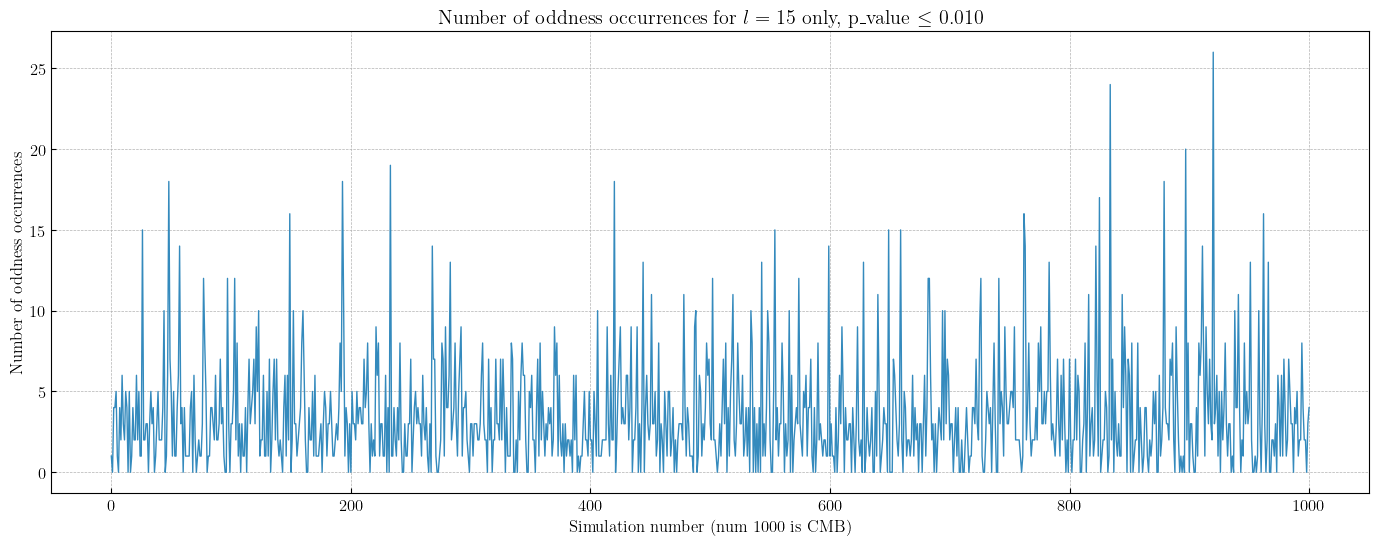

In [24]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots()
    fig.set_size_inches(17,6)
    ax.plot(maps_oddness, lw=1)
    ax.set_facecolor('white')
    # ax.yaxis.set_ticks(np.arange(24))
    ax.set_title(r"Number of oddness occurrences for $l=15$ only, p_value $ \leq $ {:.3f}".format(odd_count / 1000))
    # ax.set_title(r"Number of oddness occurrences for all parameters, p_value $ \leq $ {:.3f}".format(odd_count / 1000))
    ax.set_ylabel("Number of oddness occurrences")
    ax.set_xlabel("Simulation number (num 1000 is CMB)")
    # Axis colors
    for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
    plt.show()
    custom_save_fig(fig, fdir = base_path + "plots/", fname = "oddness_occurrence_ell15_only_pvalue{:.3f}".format(odd_count/1000))
    # custom_save_fig(fig, fdir = base_path + "plots/", fname = "oddness_occurrence_all_parameters_pvalue{:.3f}".format(odd_count/1000))

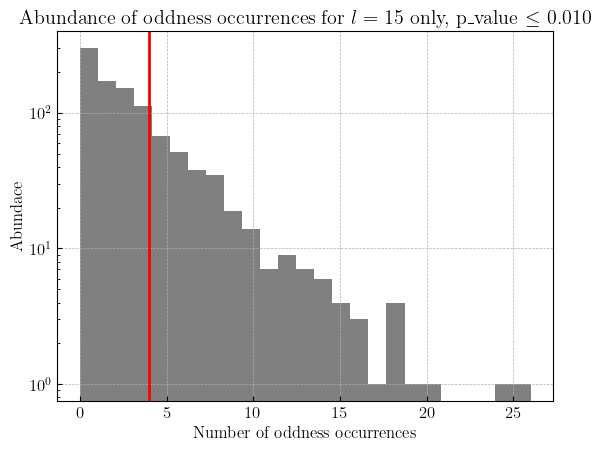

In [26]:
with plt.style.context('bmh'):
    fig, ax = plt.subplots()
    # fig.set_size_inches(17,6)
    ax.hist(maps_oddness, color="grey", bins=25)
    ax.axvline(x=maps_oddness[1000], color="r")
    ax.set_facecolor('white')
    # ax.yaxis.set_ticks(np.arange(24))
    ax.set_title(r"Abundance of oddness occurrences for $l=15$ only, p_value $ \leq $ {:.3f}".format(odd_count / 1000))
    # ax.set_title(r"Abundance of oddness occurrences for all parameters, p_value $ \leq $ {:.3f}".format(odd_count / 1000))
    ax.set_ylabel("Abundace")
    ax.set_xlabel("Number of oddness occurrences")
    ax.set_yscale('log')
    # Axis colors
    for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
    plt.show()
    custom_save_fig(fig, fdir = base_path + "plots/", fname = "hist_oddness_ell15_only_pvalue{:.3f}".format(odd_count/1000))
    # custom_save_fig(fig, fdir = base_path + "plots/", fname = "hist_oddness_all_parameters_pvalue{:.3f}".format(odd_count/1000))